# План рекламных кампаний для магазина компьютерных игр

## Описание проекта

Для интернет-магазина, который продаёт по всему миру компьютерные игры необходимо выявить определяющие успешность игры закономерности, чтобы сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. Для этого необходимо проанализировать исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation), взятые из открытых источников.

## Описание данных

- `Name` — название игры
- `Platform` — платформа
- `Year_of_Release` — год выпуска
- `Genre` — жанр игры
- `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
- `EU_sales` — продажи в Европе (миллионы проданных копий)
- `JP_sales` — продажи в Японии (миллионы проданных копий)
- `Other_sales` — продажи в других странах (миллионы проданных копий)
- `Critic_Score` — оценка критиков (максимум 100)
- `User_Score` — оценка пользователей (максимум 10)
- `Rating` — рейтинг от организации ESRB

## Оглавление
1. Подготовка данных
2. Исследовательский анализ данных
3. Сопоставление пользователей
4. Проверка гипотез 

# Подготовка данных

In [1]:
# Импортируем библиотеки, которые будут использоваться в ходе исследования
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import warnings

from scipy import stats as st
from pandas_profiling import ProfileReport

%matplotlib inline

In [2]:
try:
    df = pd.read_csv('games.csv')
except FileNotFoundError: 
    df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
ProfileReport(df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df.head(10)# Первый вгляд на данные

Name Platform  Year_of_Release         Genre  \
0                 Wii Sports      Wii           2006.0        Sports   
1          Super Mario Bros.      NES           1985.0      Platform   
2             Mario Kart Wii      Wii           2008.0        Racing   
3          Wii Sports Resort      Wii           2009.0        Sports   
4   Pokemon Red/Pokemon Blue       GB           1996.0  Role-Playing   
5                     Tetris       GB           1989.0        Puzzle   
6      New Super Mario Bros.       DS           2006.0      Platform   
7                   Wii Play      Wii           2006.0          Misc   
8  New Super Mario Bros. Wii      Wii           2009.0      Platform   
9                  Duck Hunt      NES           1984.0       Shooter   

   NA_sales  EU_sales  JP_sales  Other_sales  Critic_Score User_Score Rating  
0     41.36     28.96      3.77         8.45          76.0          8      E  
1     29.08      3.58      6.81         0.77           NaN        NaN    NaN  
2     15.68     12.76      3.79         3.29          82.0        8.3      E  
3     15.61     10.93      3.28         2.95          80.0          8      E  
4     11.27      8.89     10.22         1.00           NaN        NaN    NaN  
5     23.20      2.26      4.22         0.58           NaN        NaN    NaN  
6     11.28      9.14      6.50         2.88          89.0        8.5      E  
7     13.96      9.18      2.93         2.84          58.0        6.6      E  
8     14.44      6.94      4.70         2.24          87.0        8.4      E  
9     26.93      0.63      0.28         0.47           NaN        NaN    NaN

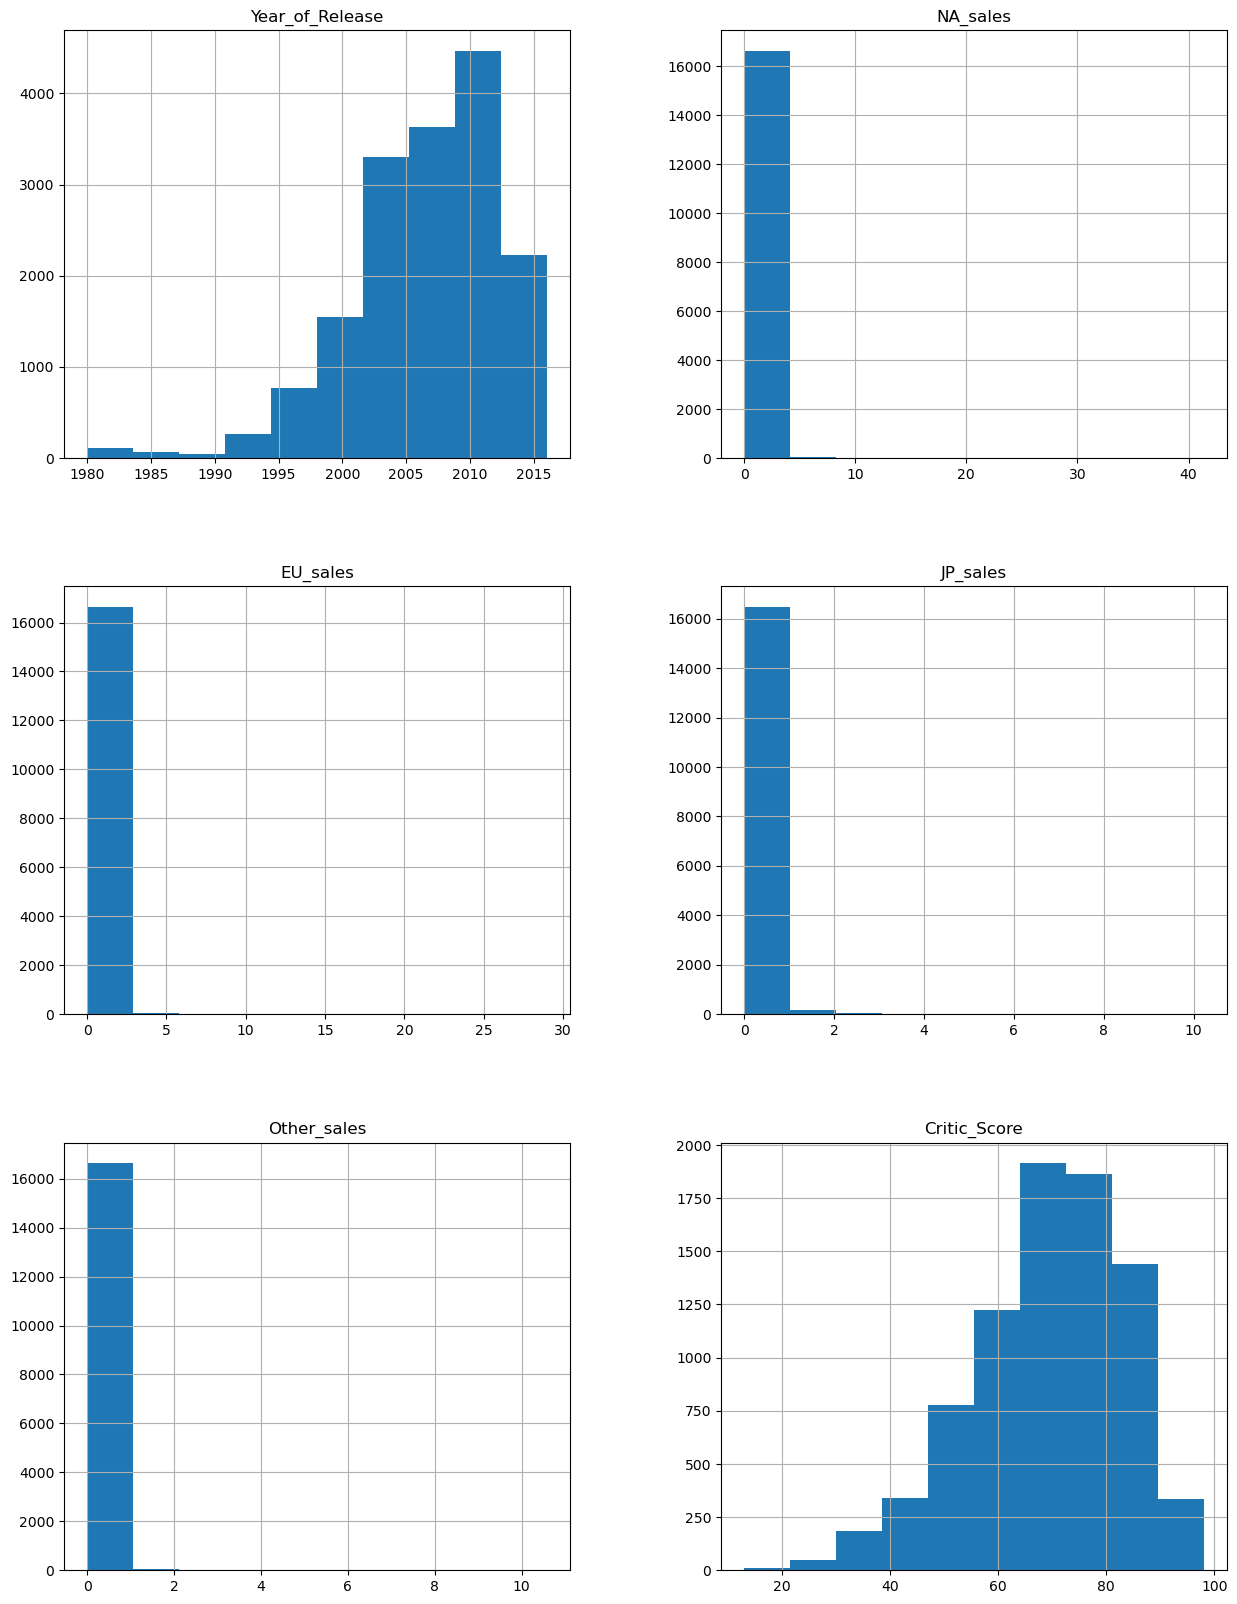

In [6]:
df.hist(figsize=(15, 20));

In [7]:
df.columns # Посмотрим на название атрибутов

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

## Промежуточный вывод

- Метод df.info() и певичный осмотр датасета показал следующие проблемы с данными:
    1.  Нужно изменить тип данных Year_of_Release (float64 -> int64).
    2.  Посмотреть как обстоят дела с Critic_Score. Если есть значения после запятой, то оставим тип данных float64 в противном случае переведем в int64.
    3.  User_score (object -> float64), предварительно будет избавляться от пропусков.
- df.columns показал, что большимнство атрибутов не отвечают нашим кретериям, будем изменять их.
- В столбце `User_Score` замечена аббревиатура *"tbd"*, которая в переводе с анлийского означает To Be Determined (будет определено) или To Be Decided (будет решено).
- Есть игры которые вовсе не продавались, обратим на такую категорию свою внимание.

## Пропуски

In [8]:
# Приведем столбы к нижнему индексу с помощью list comprehension и lower
df.columns =[column.lower() for column in df.columns]

df.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [9]:
df.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [10]:
# filtered_data = msno.nullity_filter(df, filter='bottom', n=15, p=0.999) # or filter='top

In [11]:
# msno.matrix(filtered_data.sample(100))

Анализируя матрицу пропусков можно заметить следующую тенденцию, при отсутствии значения в стобце `critic_score` вероятней всего в данной строке будет пропущено и значение в двух следующих столбцах: `user_score` `rating`. Обратное утверждение также справедливо. 
Это может свидетельствовать наличию третьего признака, влияющему на данные пропуски.

In [12]:
# С атрибутами мы разобрались, преступим к исправлению неверных типов данных и заполненижю пропусков.

# Начнем с исправления столбца 'year_of_release'. Сложность данного мероприятия заключется в наличии пропусков.
print(df['year_of_release'].isna().sum())
# Количество строк с нулями в данном столбце невелико и составляет 269, заполним данные пропуски нулями.
df['year_of_release'].fillna(0, inplace=True)
df['year_of_release'] = df['year_of_release'].astype('int64')

# Проверим, что всё отработало штатно.
print(df['year_of_release'].isna().sum())

269
0


In [13]:
# Переходим к следующему столбцу, содерщашему пропуски - 'critic_score'.
# Для начала нужно проанализировать ситуацию с числами после запятой. 

def get_last_num(value):
    if (math.isnan(value)):
        return 0
    
    return int(value % 1) #возвращаем дает остаток от деления `critic_score` аргумента на единицу, т.е. последную цифру.

df['last_num'] = df['critic_score'].apply(get_last_num)
len(df.query('last_num != 0'))

0

In [14]:
# В действительности чисел после запятой нет, можем избавиться от новосозданного столбца
del df['last_num']

In [15]:
# Прежде чем изменять тип данных для столбцов `critic_score` и `user_score` нужно разобраться с пропусками

### Промежуточный вывод

При более детальном анализе оценок от критиков и обычных пользователей была заменена одна особенность: чем старше игра, тем больше вероятность наличия пропуска в её оценках. Этот факт можно обьяснить следующим образом:
 - Во-первых, если игра действительно старая, то оценок и не может быть. (практика оценивания игр не так нова как кажется).
 - Во-вторых, если в действительности игра не получила высоких оценок, то такую информацию могли и не указывать.
 - Возможна обратная ситуация, когда игра вышла совсем недавно и не успела получить оценки пользователей и критиков.
 
Наличие такого количества противоречий не сулит ничего хорошего при банальной замене пропусков медианным или иным значением.
Так как количество пропусков очень велико нельзя просто заменить их единообразно на 0 или другую константу, это повлечет большие ошибки и неминуемо приведет к искажению результатов исследования. Нужно сжимать группы по определенным кретериям, дабы повысить качество данных внутри каждой из них.

Попробуем сделать следующее:
 - Рассчитаем медианное значение рейтинга, ориентируясь на два параметра - жанр и платформу. Это позволит сузить группы, согласно рассуждениям изложенным выше.
 - Отметим данные, которые были нами модифицированы, дабы отслеживать в дальнейшем не привело ли это к заметным изминениям в общей картине.

## Дубликаты 

In [16]:
df['platform'].value_counts() # Дубликатов не обнаружено

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       29
NG        12
SCD        6
WS         6
3DO        3
TG16       2
GG         1
PCFX       1
Name: platform, dtype: int64

In [17]:
df['genre'].value_counts() # Аналогично дубликатов не найдено

Action          3369
Sports          2348
Misc            1750
Role-Playing    1498
Shooter         1323
Adventure       1303
Racing          1249
Platform         888
Simulation       873
Fighting         849
Strategy         683
Puzzle           580
Name: genre, dtype: int64

In [18]:
df[df['genre'].isna()] # Выявлены две строки в которых пропущен жанр. Однако они датируются 1993 годом. Удалим их.

name platform  year_of_release genre  na_sales  eu_sales  jp_sales  \
659    NaN      GEN             1993   NaN      1.78      0.53      0.00   
14244  NaN      GEN             1993   NaN      0.00      0.00      0.03   

       other_sales  critic_score user_score rating  
659           0.08           NaN        NaN    NaN  
14244         0.00           NaN        NaN    NaN

In [19]:
df.dropna(subset=['genre'], inplace=True)

In [20]:
display(df[df['user_score'] == 'tbd'])

name platform  year_of_release  \
119                               Zumba Fitness      Wii             2010   
301              Namco Museum: 50th Anniversary      PS2             2005   
520                             Zumba Fitness 2      Wii             2011   
645                                uDraw Studio      Wii             2010   
657    Frogger's Adventures: Temple of the Frog      GBA                0   
...                                         ...      ...              ...   
16695                           Planet Monsters      GBA             2001   
16697                          Bust-A-Move 3000       GC             2003   
16698                          Mega Brain Boost       DS             2008   
16704                                  Plushees       DS             2008   
16706             Men in Black II: Alien Escape       GC             2003   

            genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
119        Sports      3.45      2.59       0.0         0.66           NaN   
301          Misc      2.08      1.35       0.0         0.54          61.0   
520        Sports      1.51      1.03       0.0         0.27           NaN   
645          Misc      1.65      0.57       0.0         0.20          71.0   
657     Adventure      2.15      0.18       0.0         0.07          73.0   
...           ...       ...       ...       ...          ...           ...   
16695      Action      0.01      0.00       0.0         0.00          67.0   
16697      Puzzle      0.01      0.00       0.0         0.00          53.0   
16698      Puzzle      0.01      0.00       0.0         0.00          48.0   
16704  Simulation      0.01      0.00       0.0         0.00           NaN   
16706     Shooter      0.01      0.00       0.0         0.00           NaN   

      user_score rating  
119          tbd      E  
301          tbd   E10+  
520          tbd      T  
645          tbd      E  
657          tbd      E  
...          ...    ...  
16695        tbd      E  
16697        tbd      E  
16698        tbd      E  
16704        tbd      E  
16706        tbd      T  

[2424 rows x 11 columns]

In [21]:
# Выходит для 2424 игр оценка пользователей не определена. 
# Заменим данное значение на -1, чтобы выделить группу данных игр в дальнейшем анализе.
df.loc[df['user_score'] == 'tbd', 'user_score'] = -1

In [22]:
# Продублируем в нашем датафрейме два столбца, которые вскоре подвергнем модификации, 
# оставляя за собой возможность в нужный момент проанализовать исходные данные.
df['critis_score_raw'] = df['critic_score']
df['user_score_raw'] = df['user_score']

In [23]:
# msno.dendrogram(df) # Дендрограмма данных после проведенных преобразований

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Импорт библиотек стоит выносить на первые строки проекта, так коллегам будет удобнее настроить свои рабочие места под наши требования

<div class="alert alert-info"> <b>Комментарий студента:</b> Перенёс </div>

In [24]:
# Приступим к написанию функцию, что поможет нам считать медиану по заданным параметрам (жанру и платформе)
def calc_score(df, genre, platform, field):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning) # Эта штуку подсмотрел на stackoverflow она погомает обработать ошибку
        #RuntimeWarning: Mean of empty slice

        # ориентируемся на оба параметра
        median = df[(df['genre'] == genre) & (df['platform'] == platform)][field].median()
        # Не факт, что в очередной строке мы найдем оба параметра для вычисления медианы, поэтому необходимо предусмотреть возмодность
        # вычисления медианы по одному из параметров.
        if math.isnan(median):
            median = df[df['genre'] == genre][field].median()
            if math.isnan(median):
                median = df[df['platform'] == platform][field].median()    
        return median

In [25]:
unique_genre = df['genre'].unique()
unique_platform = df['platform'].unique()
score_list = ['critic_score', 'user_score']

# идем по всем жанрам и платформам и заполняем для них пропуски (как для рейтинга критиков, так и пользователей)
for score_type in score_list:
    for genre in unique_genre:
        for platform in unique_platform:
            median = calc_score(df, genre, platform, score_type)
            searchRow = (df['genre'] == genre) & (df['platform'] == platform) & (df[score_type].isnull())
            df.loc[searchRow, score_type] = df.loc[searchRow, score_type].fillna(median)    

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />Ты проделал большую работу по восстановлению пропусков. Но такую значительную долю пропусков вряд ли можно корректно восстановить по имеющимся значениям
        
[Обработка пропусков в данных](https://loginom.ru/blog/missing)

<div class="alert alert-info"> <b>Комментарий студента:</b> Действительно количество пропусков существенно, но я предпринял максимально возможные усилия дабы свести неточности при их востановлении на нет. </div>

In [26]:
# изменим типы
df['critic_score'] = df['critic_score'].astype('int64')
df['user_score'] = df['user_score'].astype('float64')

# проверим, что все получилось
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16713 entries, 0 to 16714
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   name              16713 non-null  object 
 1   platform          16713 non-null  object 
 2   year_of_release   16713 non-null  int64  
 3   genre             16713 non-null  object 
 4   na_sales          16713 non-null  float64
 5   eu_sales          16713 non-null  float64
 6   jp_sales          16713 non-null  float64
 7   other_sales       16713 non-null  float64
 8   critic_score      16713 non-null  int64  
 9   user_score        16713 non-null  float64
 10  rating            9949 non-null   object 
 11  critis_score_raw  8137 non-null   float64
 12  user_score_raw    10014 non-null  object 
dtypes: float64(6), int64(2), object(5)
memory usage: 1.8+ MB


### Промежуточный вывод
 - Проверены столбцы `platform` и `genre` на наличие дубликатов.
 - Создана функция `calc_score`, автоматизирующая подсчет медианного значения рейтинга критиков, так и пользовательтей.
 - Устранены пропуски в рейтинге критиков и пользователей.
 - Изменены типы данных в соотвутсвующих столбцах.
 
 На очереди устранение пропусков в столбце `rating`. Для корректого выполнения этого действия необходимо понять каким методом предпочтительней будет заполнить пропущенные значения. Мода, медиана, среднее?

In [27]:
df['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

![title](https://i.pinimg.com/originals/48/c0/0d/48c00db3e368b37e97dd53d6e270f39a.png)

<AxesSubplot:>

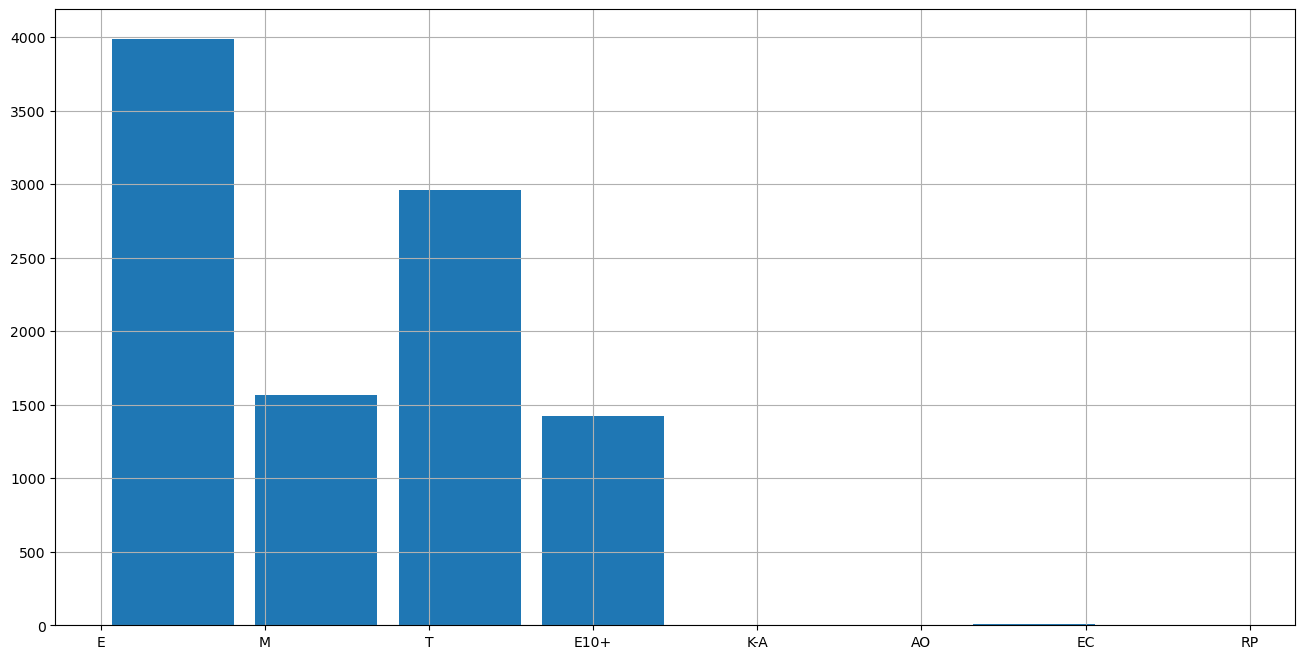

In [28]:
df['rating'].hist(bins=8,rwidth=0.85, figsize=(16,8))     

Нарисовалась четверка лидеров, подавляющее большинство фильмов получили именно эту оценку.

Также мы убедились в том, что данный столбец содержит категориальные переменные, а именно возрастной рейтинг, поэтому наиболее точным методом заполнения пропусков я считаю моду по жанру фильма. Так как мода покажет какую возростную категорию наиболее часто получали фильмы данного жанра, это ближе к реальности чем медиана и уж тем более среднее.

In [29]:
## Если по простому, то мода - самое популярное значение, то что "ставят всем"
#for genre in df['genre'].unique():
#    mask = df['genre'] == genre # Бинарная маска для каждого жарна из списка уникальных жанров
#    moda = df.loc[mask, 'rating'].mode()[0]
#    df.loc[mask, 'rating'] = df.loc[mask, 'rating'].fillna(moda)

In [30]:
df['rating'] = df['rating'].fillna('unknown')

<AxesSubplot:>

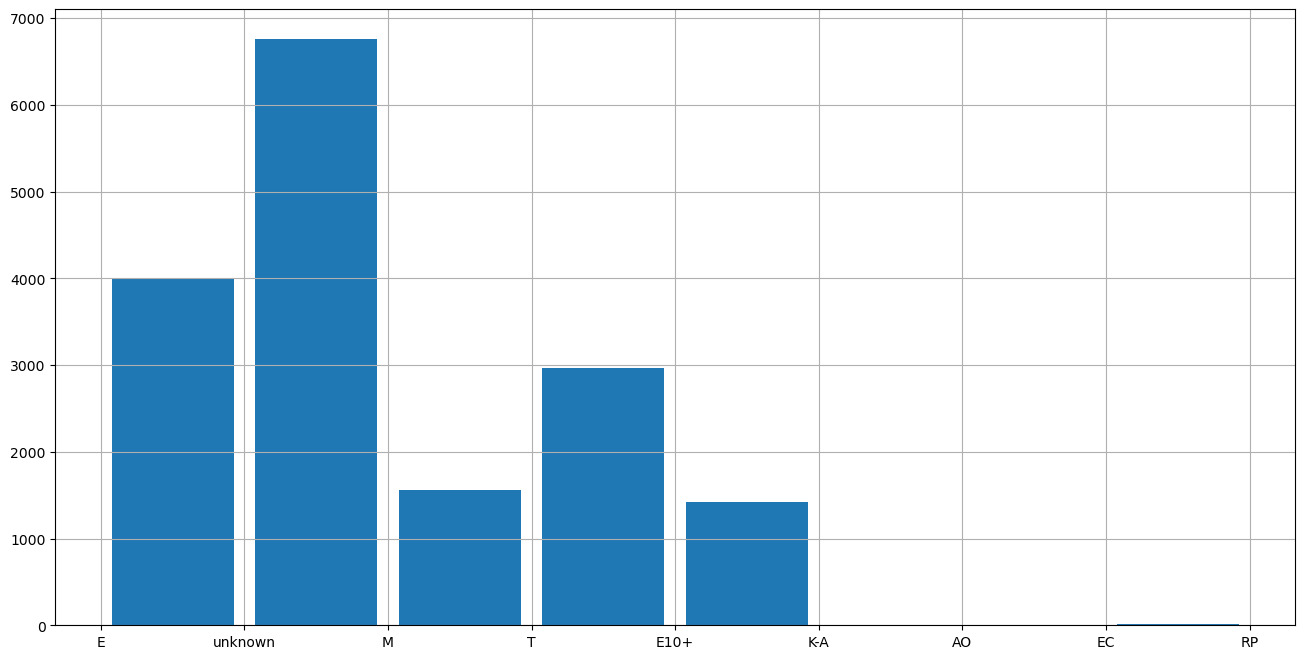

In [31]:
df['rating'].hist(bins=8,rwidth=0.85, figsize=(16,8))     

<div class="alert alert-warning", style="border:solid coral 3px; padding: 20px">
<font size="4", color = "DimGrey"><b>⚠️ Комментарий ревьюера</b></font>
    <br /> 
    <font size="3", color = "black">
<br />
Ты проделал работу по восстановлению пропусков. Но иногда пропуск сам по себе является ценной информацией. Для каких стран создавалась система ESRB? Будут ли стараться авторы игр для локального рынка других стран получить рейтинг ESRB?
        
Оптимальнее на данном проекте использовать категорию «неизвестный рейтинг» ...

<div class="alert alert-info"> <b>Комментарий студента:</b> Рейтинг ESRB явно создавался Америкамцами как и подавляющие большинство других рейтингов. А Американцы людят нести свои ценности по всему миру, однако как мы выясним в будущем от рынка Японии из-за скудных продаж можно чуть ли не полностью отказаться. 
    
Мне не кажется, что 7000 игр с неизвестным рейтингом это верный путь.</div>

In [32]:
df.isna().sum() # Пропусков не осталось, двигаемся дальше, посмотрим на явные и неявные дубликаты в датафрейме

name                   0
platform               0
year_of_release        0
genre                  0
na_sales               0
eu_sales               0
jp_sales               0
other_sales            0
critic_score           0
user_score             0
rating                 0
critis_score_raw    8576
user_score_raw      6699
dtype: int64

In [33]:
df.duplicated().sum() # Дубликатов нет

0

In [34]:
df.head(30) # Быстрый осмотр данных не выявил нужны искать неявные дуликаты в наших данных.

name platform  year_of_release  \
0                                     Wii Sports      Wii             2006   
1                              Super Mario Bros.      NES             1985   
2                                 Mario Kart Wii      Wii             2008   
3                              Wii Sports Resort      Wii             2009   
4                       Pokemon Red/Pokemon Blue       GB             1996   
5                                         Tetris       GB             1989   
6                          New Super Mario Bros.       DS             2006   
7                                       Wii Play      Wii             2006   
8                      New Super Mario Bros. Wii      Wii             2009   
9                                      Duck Hunt      NES             1984   
10                                    Nintendogs       DS             2005   
11                                 Mario Kart DS       DS             2005   
12                   Pokemon Gold/Pokemon Silver       GB             1999   
13                                       Wii Fit      Wii             2007   
14                            Kinect Adventures!     X360             2010   
15                                  Wii Fit Plus      Wii             2009   
16                            Grand Theft Auto V      PS3             2013   
17                 Grand Theft Auto: San Andreas      PS2             2004   
18                             Super Mario World     SNES             1990   
19  Brain Age: Train Your Brain in Minutes a Day       DS             2005   
20                 Pokemon Diamond/Pokemon Pearl       DS             2006   
21                              Super Mario Land       GB             1989   
22                           Super Mario Bros. 3      NES             1988   
23                            Grand Theft Auto V     X360             2013   
24                   Grand Theft Auto: Vice City      PS2             2002   
25                 Pokemon Ruby/Pokemon Sapphire      GBA             2002   
26   Brain Age 2: More Training in Minutes a Day       DS             2005   
27                   Pokemon Black/Pokemon White       DS             2010   
28                        Gran Turismo 3: A-Spec      PS2             2001   
29                Call of Duty: Modern Warfare 3     X360             2011   

           genre  na_sales  eu_sales  jp_sales  other_sales  critic_score  \
0         Sports     41.36     28.96      3.77         8.45            76   
1       Platform     29.08      3.58      6.81         0.77            69   
2         Racing     15.68     12.76      3.79         3.29            82   
3         Sports     15.61     10.93      3.28         2.95            80   
4   Role-Playing     11.27      8.89     10.22         1.00            73   
5         Puzzle     23.20      2.26      4.22         0.58            68   
6       Platform     11.28      9.14      6.50         2.88            89   
7           Misc     13.96      9.18      2.93         2.84            58   
8       Platform     14.44      6.94      4.70         2.24            87   
9        Shooter     26.93      0.63      0.28         0.47            72   
10    Simulation      9.05     10.95      1.93         2.74            65   
11        Racing      9.71      7.47      4.13         1.90            91   
12  Role-Playing      9.00      6.18      7.20         0.71            73   
13        Sports      8.92      8.03      3.60         2.15            80   
14          Misc     15.00      4.89      0.24         1.69            61   
15        Sports      9.01      8.49      2.53         1.77            80   
16        Action      7.02      9.09      0.98         3.96            97   
17        Action      9.43      0.40      0.41        10.57            95   
18      Platform     12.78      3.75      3.54         0.55            69   
19          Misc      4.74      9.20      4.16         2.04            77   
20  Role

In [35]:
df = df.reset_index(drop=True) # Сбросим индексы

In [36]:
# Последнее в данном разделе, создание столбца с суммарным количеством продаж игры.
df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)
# посмотрим что получилось
df.head()

name platform  year_of_release         genre  na_sales  \
0                Wii Sports      Wii             2006        Sports     41.36   
1         Super Mario Bros.      NES             1985      Platform     29.08   
2            Mario Kart Wii      Wii             2008        Racing     15.68   
3         Wii Sports Resort      Wii             2009        Sports     15.61   
4  Pokemon Red/Pokemon Blue       GB             1996  Role-Playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score   rating  \
0     28.96      3.77         8.45            76         8.0        E   
1      3.58      6.81         0.77            69         7.0  unknown   
2     12.76      3.79         3.29            82         8.3        E   
3     10.93      3.28         2.95            80         8.0        E   
4      8.89     10.22         1.00            73         7.8  unknown   

   critis_score_raw user_score_raw  total_sales  
0              76.0              8        82.54  
1               NaN            NaN        40.24  
2              82.0            8.3        35.52  
3              80.0              8        32.77  
4               NaN            NaN        31.38

<div style="border:solid steelblue 3px; padding: 20px">
<font size="4">🍕<b> Комментарий ревьюера</b></font>
<br /> 
<font size="3", color = "black">
<br />
можно
    
    df['total_sales'] = df[['na_sales','eu_sales','jp_sales', 'other_sales']].sum(axis = 1)

<div class="alert alert-info"> <b>Комментарий студента:</b> Спасибо, так действительно более элегантно выглядит.</div>

In [37]:
df = df.reindex(columns=[
    'name', 'platform', 'year_of_release', 'genre', 'na_sales', 
    'eu_sales','jp_sales', 'other_sales', 'total_sales','critic_score', 
    'critis_score_raw', 'user_score', 'user_score_raw','rating'])

## Вывод по подготовке данных

1. Изменены названия столбцов, все приведены к нижнему регистру
2. Устранены все пропуски, пропущенные значения заполнены наиболее подходящим образом.
3. Изменены типы данных:
    - `Year_of_Release` (float64 -> int64)
    - `critic_score` (float64 -> int64)
4. Данные проверены на наличие явных и неявных дубликатов.
5. Добавлены три 'новых' столбца
    - `critis_score_raw` и `user_score_raw` могут потребоваться в случае выявления ошибки в заполеннии пропусков.
    - `total_sales` суммарные продажи игры по всему миру.
6. Изменен порядок столбцов

# Исследовательский анализ данных

In [38]:
df['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
0        269
1996     263
1995     219
1994     121
1993      60
1981      46
1992      43
1991      41
1982      36
1986      21
1989      17
1983      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

## Промежуточный вывод
Данный этап анализа показал, что условно активно игровая индустрия, согласно нашему датасету начала своё развитие после 1990-1995 года. (Можем спокойно удалить данные о более старых играх.) (под вопросом)

In [39]:
df = df.query('year_of_release >= 1995')

In [40]:
#Оценим изминение продаж игр на разных платформах с течением времени. Отсортируем платформы по убыванию суммарных продаж

platforms_top = df.groupby('platform')['total_sales'].sum().nlargest(15)
platforms_top

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       721.55
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
XB       251.57
PC       239.79
N64      218.01
GC       196.73
XOne     159.32
Name: total_sales, dtype: float64

In [41]:
def calc_bins(start, end, step):
    list_bins = []
    for b in range(start, end+1, step):
        list_bins.append(b)
    return list_bins

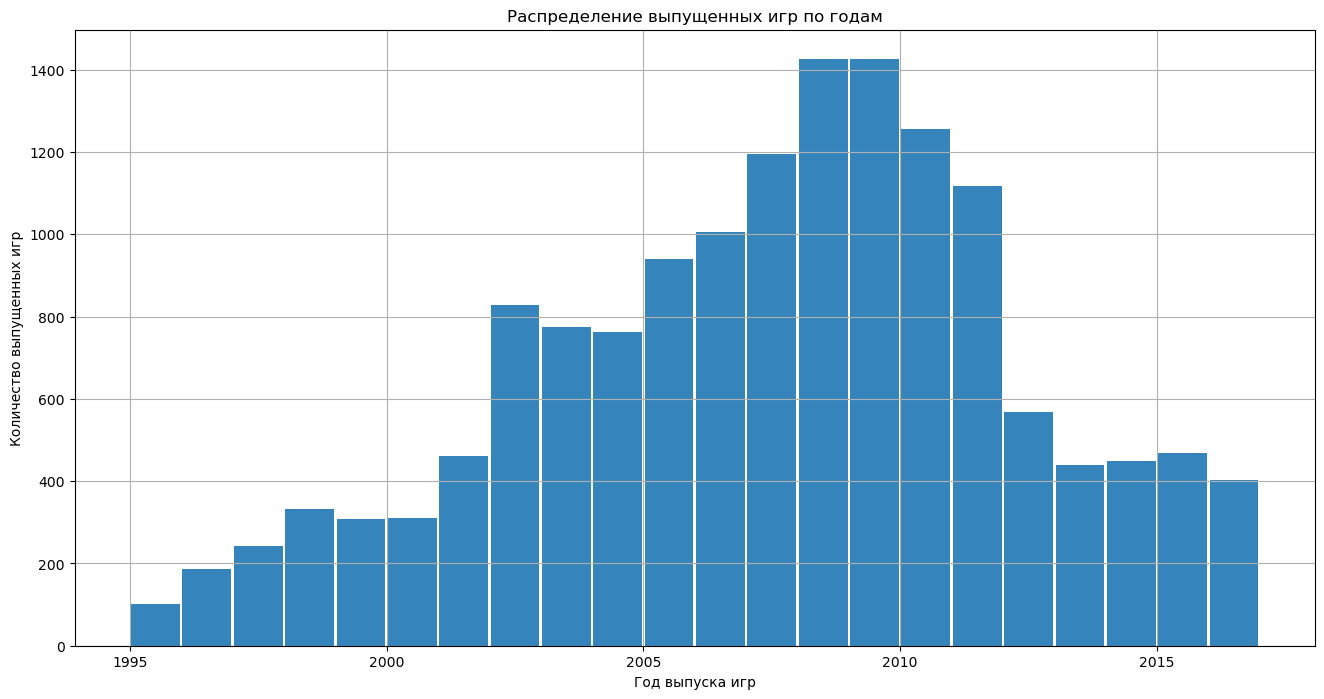

In [42]:
# Построим гистограмму распределения выпущенных игр по годам
df_platforms_top = df.query('(platform in @platforms_top.index) and (year_of_release >= 1995)')


fig, ax = plt.subplots()
    
ax.hist(df_platforms_top['year_of_release'], bins=calc_bins(1995,2017,1),alpha=0.9,rwidth=0.95)
ax.grid() 
ax.set_title("Распределение выпущенных игр по годам",)
ax.set_xlabel('Год выпуска игр')
ax.set_ylabel('Количество выпущенных игр')

fig.set_figheight(8)
fig.set_figwidth(16)
plt.show()

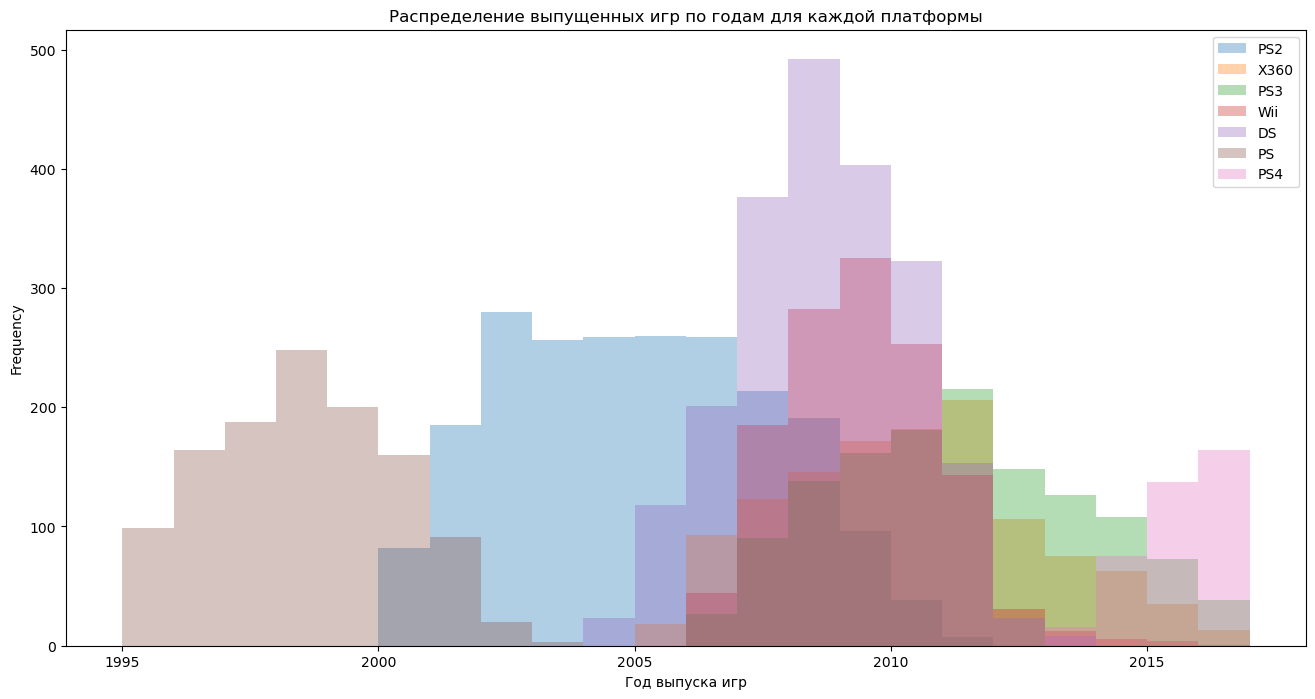

In [43]:
# Построим схожую гистограму распределения но только по каждой платформе отдельно

fig, ax = plt.subplots()
ax.set_title("Распределение выпущенных игр по годам для каждой платформы")
ax.set_xlabel('Год выпуска игр')
ax.set_ylabel('Количество выпущенных игр')

mean_dict = dict()

for platform in platforms_top.nlargest(7).index.tolist():
    df_platform = df_platforms_top.query('platform == @platform')
    
    min_year = df_platform['year_of_release'].min()
    max_year = df_platform['year_of_release'].max()
    mean_dict[platform] = max_year - min_year
    
    bins = calc_bins(min_year, max_year+1, 1)
    df_platform['year_of_release'].plot(kind='hist',bins=bins, figsize=(16,8), alpha=0.35, ax=ax)
    
    ax.legend(platforms_top.nlargest(7).index.tolist())
plt.show()

In [44]:
mean_dict 

{'PS2': 11, 'X360': 11, 'PS3': 10, 'Wii': 10, 'DS': 9, 'PS': 8, 'PS4': 3}

In [45]:
mean = sum(mean_dict.values()) / len(mean_dict.values()) #Попробуем убрать из нашего списка два устройства которые выбиваются из общей картины
mean

8.857142857142858

In [46]:
del mean_dict['PS4']

mean = sum(mean_dict.values()) / len(mean_dict.values())
mean

9.833333333333334

## Промежуточный вывод
Согласно проведенному исследованию средний жизненный цикл игровой платформы составляет около 8.9 лет.
Есть одно исключение - PS4 (вышедшая недавно), если её убрать, то средняя продолжительности жизни игровых платформ вырастет до 9.8 лет.

In [47]:
df_nowadays = df.query('(year_of_release >= 2006) and (platform in @platforms_top.index)')
# Актуальный период последних 10 лет в нашем датафрейме.
df_nowadays_pivot = (
    df_nowadays
    .pivot_table(index='platform', values='total_sales', aggfunc='sum')
    .sort_values(by='total_sales',ascending = False)
)
df_nowadays_pivot = df_nowadays_pivot.query('total_sales > 50')

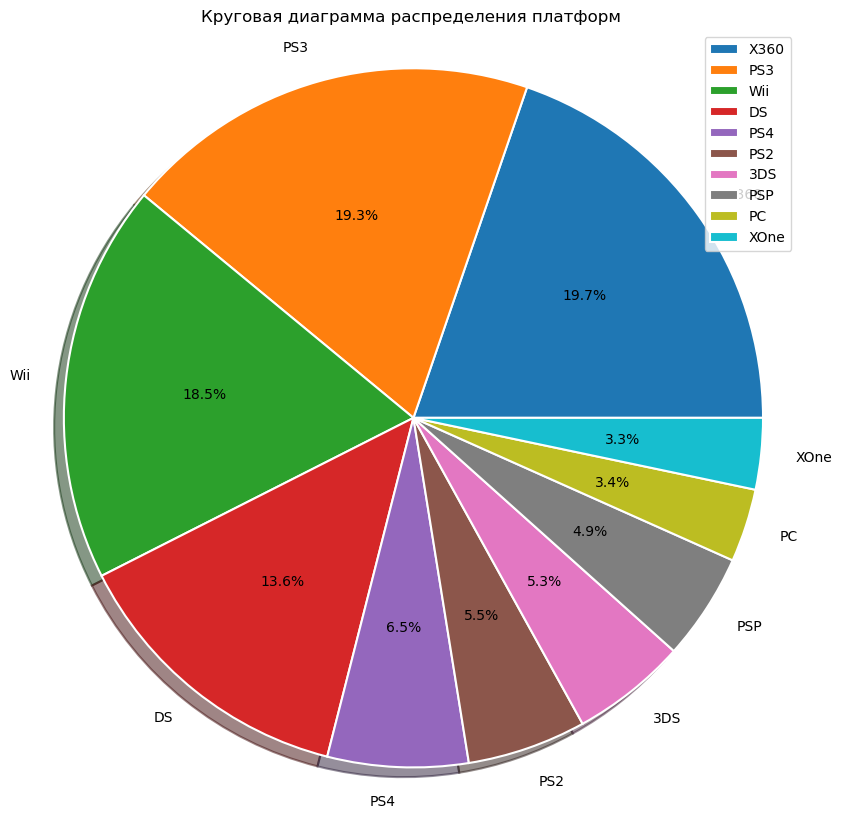

In [48]:
# from palettable.cmocean.sequential import Amp_10

fig, ax = plt.subplots()
ax.pie(
    df_nowadays_pivot['total_sales'], 
    autopct='%1.1f%%', 
    shadow = True, 
    #frame = True, 
    labels = df_nowadays_pivot.index.tolist(),
    wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'WHITE' },
#     colors=Amp_10.hex_colors
)

ax.set_title('Круговая диаграмма распределения платформ')
ax.axis('equal')
fig.set_figheight(10)
fig.set_figwidth(10)
ax.legend(df_nowadays_pivot.index.tolist())
plt.show()

In [49]:
#Какие платформы лидируют по продажам, растут или падают?
df_platform_pivot = df_nowadays.pivot_table(index = ['platform', 'year_of_release'], values = 'total_sales', aggfunc = 'sum')
df_platform_pivot = df_platform_pivot.reset_index(level = 'year_of_release')
df_platform_pivot.columns= ['year', 'sales_sum']

df_platform_pivot = df_platform_pivot.reset_index()
df_platform_pivot

platform  year  sales_sum
0       3DS  2011      63.20
1       3DS  2012      51.36
2       3DS  2013      56.57
3       3DS  2014      43.76
4       3DS  2015      27.78
..      ...   ...        ...
84       XB  2008       0.18
85     XOne  2013      18.96
86     XOne  2014      54.07
87     XOne  2015      60.14
88     XOne  2016      26.15

[89 rows x 3 columns]

In [50]:
df_platform_pivot = df_platform_pivot.pivot_table(index= 'year', columns='platform', values= 'sales_sum')


In [51]:
df_platform_pivot

platform    3DS      DS   GBA     GC     PC     PS2     PS3     PS4    PSP  \
year                                                                         
2006        NaN  119.81  5.28  11.26   2.85  103.42   20.96     NaN  55.32   
2007        NaN  146.94  3.40   0.27   9.28   75.99   73.19     NaN  46.93   
2008        NaN  145.31   NaN    NaN  12.42   53.90  118.52     NaN  34.55   
2009        NaN  119.54   NaN    NaN  16.91   26.40  130.93     NaN  37.78   
2010        NaN   85.02   NaN    NaN  24.28    5.64  142.17     NaN  35.04   
2011      63.20   26.18   NaN    NaN  35.03    0.45  156.78     NaN  17.82   
2012      51.36   11.01   NaN    NaN  23.22     NaN  107.36     NaN   7.69   
2013      56.57    1.54   NaN    NaN  12.38     NaN  113.25   25.99   3.14   
2014      43.76     NaN   NaN    NaN  13.28     NaN   47.76  100.00   0.24   
2015      27.78     NaN   NaN    NaN   8.52     NaN   16.82  118.90   0.12   
2016      15.14     NaN   NaN    NaN   5.25     NaN    3.60   69.25    NaN   

platform     Wii    X360     XB   XOne  
year                                    
2006      137.15   51.62  10.04    NaN  
2007      152.77   95.41   0.55    NaN  
2008      171.32  135.26   0.18    NaN  
2009      206.97  120.29    NaN    NaN  
2010      127.95  170.03    NaN    NaN  
2011       59.65  143.84    NaN    NaN  
2012       21.71   99.74    NaN    NaN  
2013        8.59   88.58    NaN  18.96  
2014        3.75   34.74    NaN  54.07  
2015        1.14   11.96    NaN  60.14  
2016        0.18    1.52    NaN  26.15

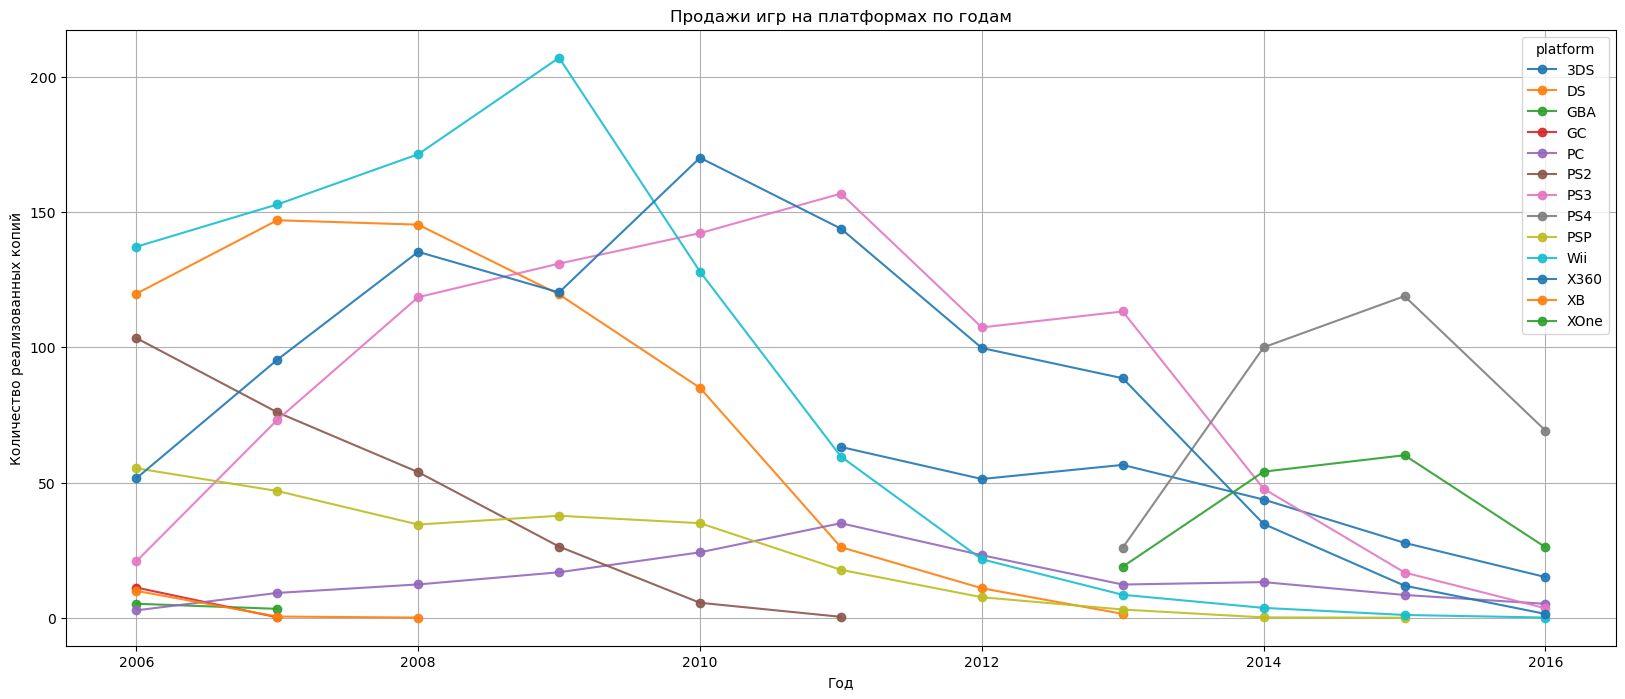

In [52]:
#from palettable.cmocean.sequential import Matter_16
df_platform_pivot.plot(
    kind='line',
    figsize= (20,8), 
    style='o-', 
    alpha=0.9,
    legend= True, 
    grid =True, 
    title='Продажи игр на платформах по годам', 
    xlabel='Год',
    ylabel = 'Количество реализованных копий',
    #colormap = Matter_16.mpl_colormap
        );

## Промежуточный вывод

Согласно проведенному анализу и построенным графикам стало понятно, что на рубеже 2013 года случилась смена поколений. 

 - Бывшие фавориты, такие как 'DC' и 'Xbox360' уходят в небытие и на сцену поднимаются новые звезды в лице 'PS4', 'XOne', вечная классика в виде настольного ПК попрежнему жива и процветает, пусть и не так сильно как консоли.
 - Также важно отметить, что данные за 2016 год скорее всего неполные, т.е. собраны в середине года или ближе к концу. Итоговые значения должны были показать значительный рост, превышающие значения за 2015 год.

Стоит отдельно построить график за меньший период, скажем с 2013 года, дабы отсеять платформы, уходящие в историю. (дальше логичней строить выводы на основе этих данных)

In [53]:
df_now = df.query('(year_of_release >= 2013) and (platform in @platforms_top.index)')

In [54]:
df_nowadays = df.query('(year_of_release >= 2013) and (platform in @platforms_top.index)')# Актуальный период последних 10 лет в нашем датафрейме.
df_nowadays_pivot = df_nowadays.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales',ascending = False)

df_nowadays_pivot = df_nowadays_pivot.query('total_sales > 10')

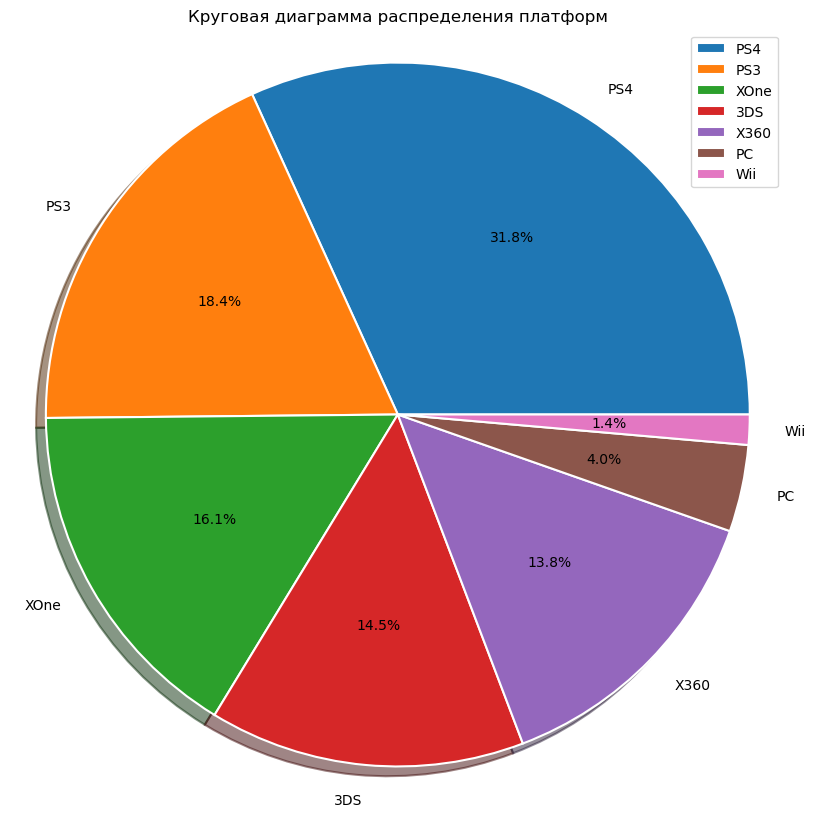

In [55]:
# from palettable.cmocean.sequential import Amp_7

fig, ax = plt.subplots()
ax.pie(
    df_nowadays_pivot['total_sales'], 
    autopct='%1.1f%%', 
    shadow = True, 
    #frame = True, 
    labels = df_nowadays_pivot.index.tolist(),
    wedgeprops = { 'linewidth' : 1.5, 'edgecolor' : 'WHITE' },
#     colors=Amp_10.hex_colors
)

ax.set_title('Круговая диаграмма распределения платформ')
ax.axis('equal')
fig.set_figheight(10)
fig.set_figwidth(10)
ax.legend(df_nowadays_pivot.index.tolist())
plt.show()

In [56]:
df_now_pivot = df_now.pivot_table(index = ['platform', 'year_of_release'], values = 'total_sales', aggfunc = 'sum')
df_now_pivot = df_now_pivot.reset_index(level = 'year_of_release')
df_now_pivot.columns= ['year', 'sales_sum']

df_now_pivot = df_now_pivot.reset_index()
#df_now_pivot

In [57]:
df_now_pivot = df_now_pivot.pivot_table(index= 'year', columns='platform', values= 'sales_sum')

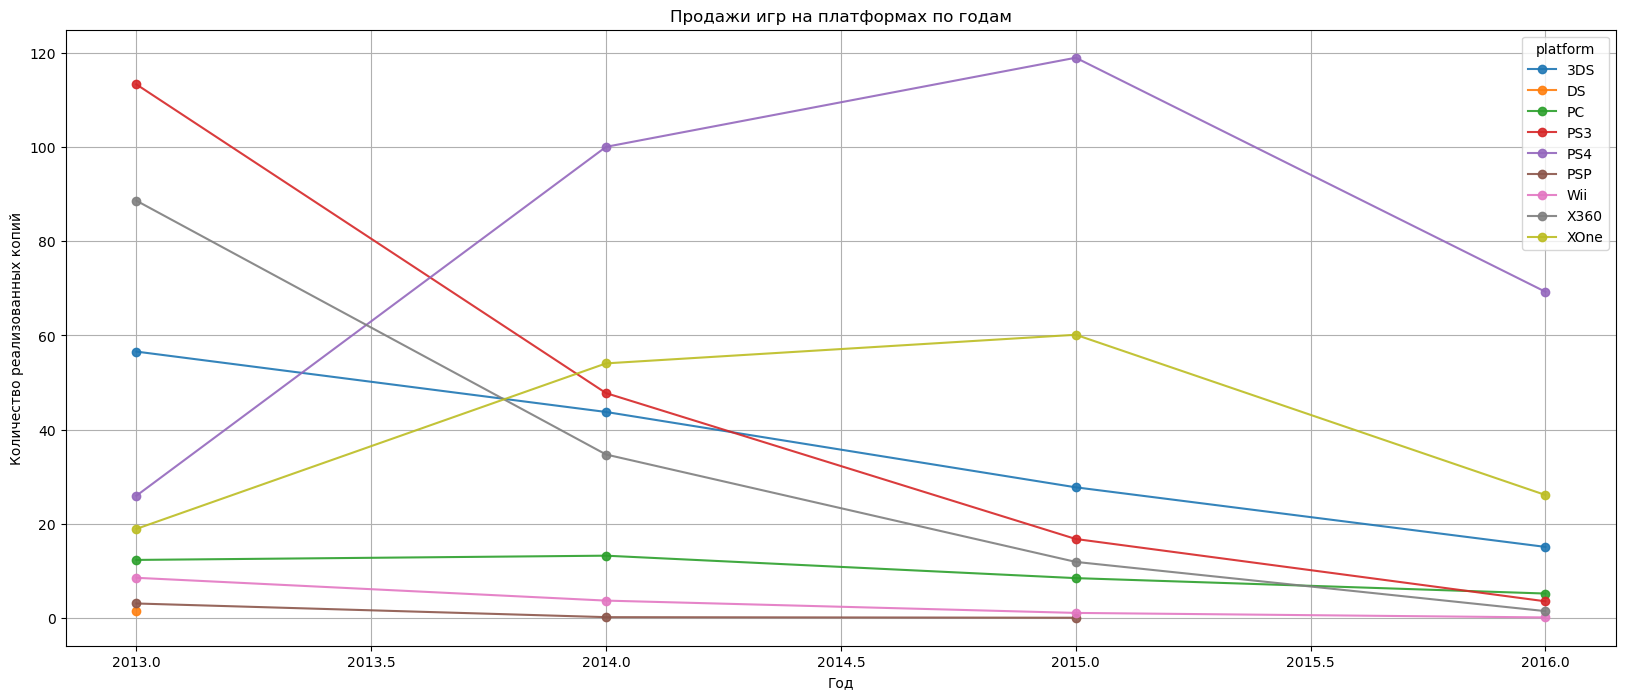

In [58]:
df_now_pivot.plot(
    kind = 'line',
    figsize = (20,8), 
    style = 'o-', 
    alpha = 0.9,
    legend = True, 
    grid = True, 
    title = 'Продажи игр на платформах по годам', 
    xlabel = 'Год',
    ylabel = 'Количество реализованных копий',
    );

In [59]:
df_now_pivot.fillna(0, inplace=True)

In [60]:
df_now_pivot

platform    3DS    DS     PC     PS3     PS4   PSP   Wii   X360   XOne
year                                                                  
2013      56.57  1.54  12.38  113.25   25.99  3.14  8.59  88.58  18.96
2014      43.76  0.00  13.28   47.76  100.00  0.24  3.75  34.74  54.07
2015      27.78  0.00   8.52   16.82  118.90  0.12  1.14  11.96  60.14
2016      15.14  0.00   5.25    3.60   69.25  0.00  0.18   1.52  26.15

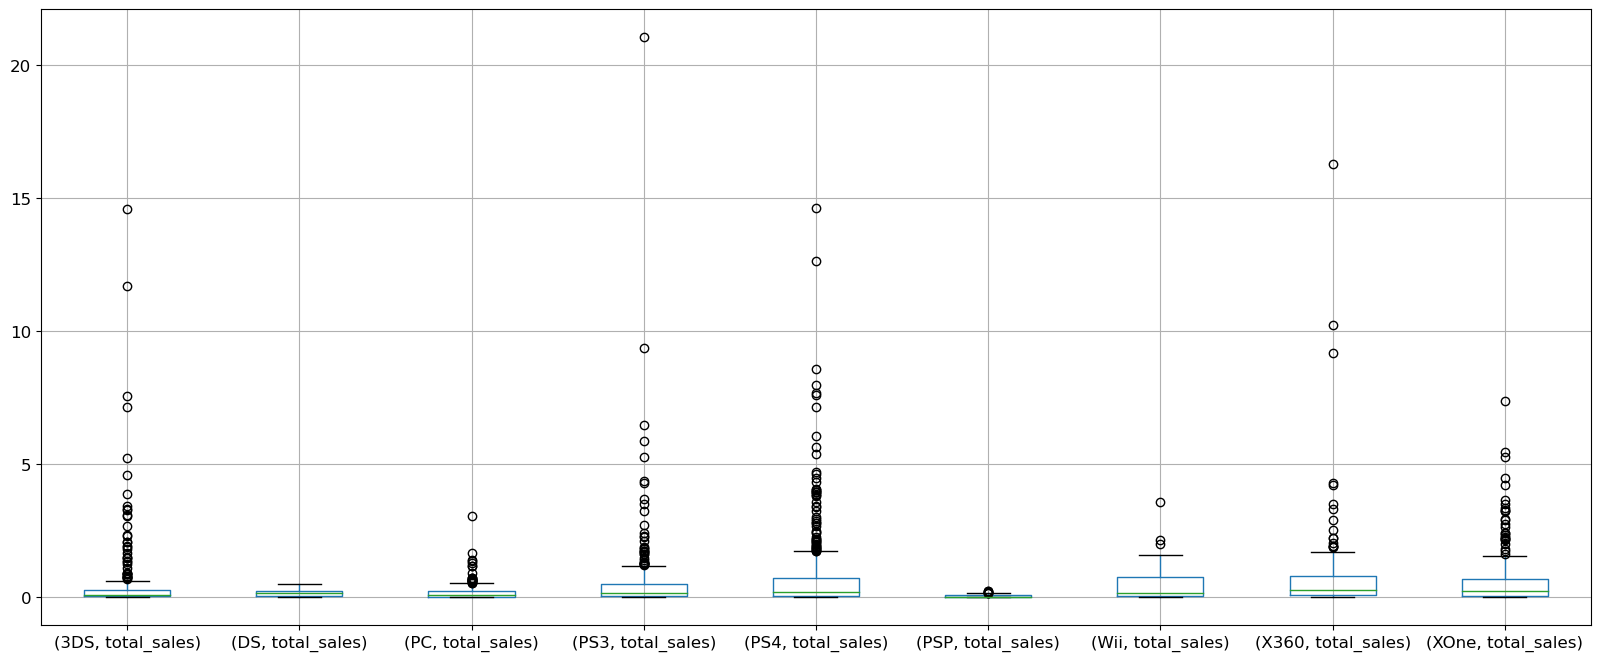

In [61]:
df_now.groupby("platform").boxplot(column="total_sales",subplots=False, figsize=(20,8), fontsize=12, grid=True); #

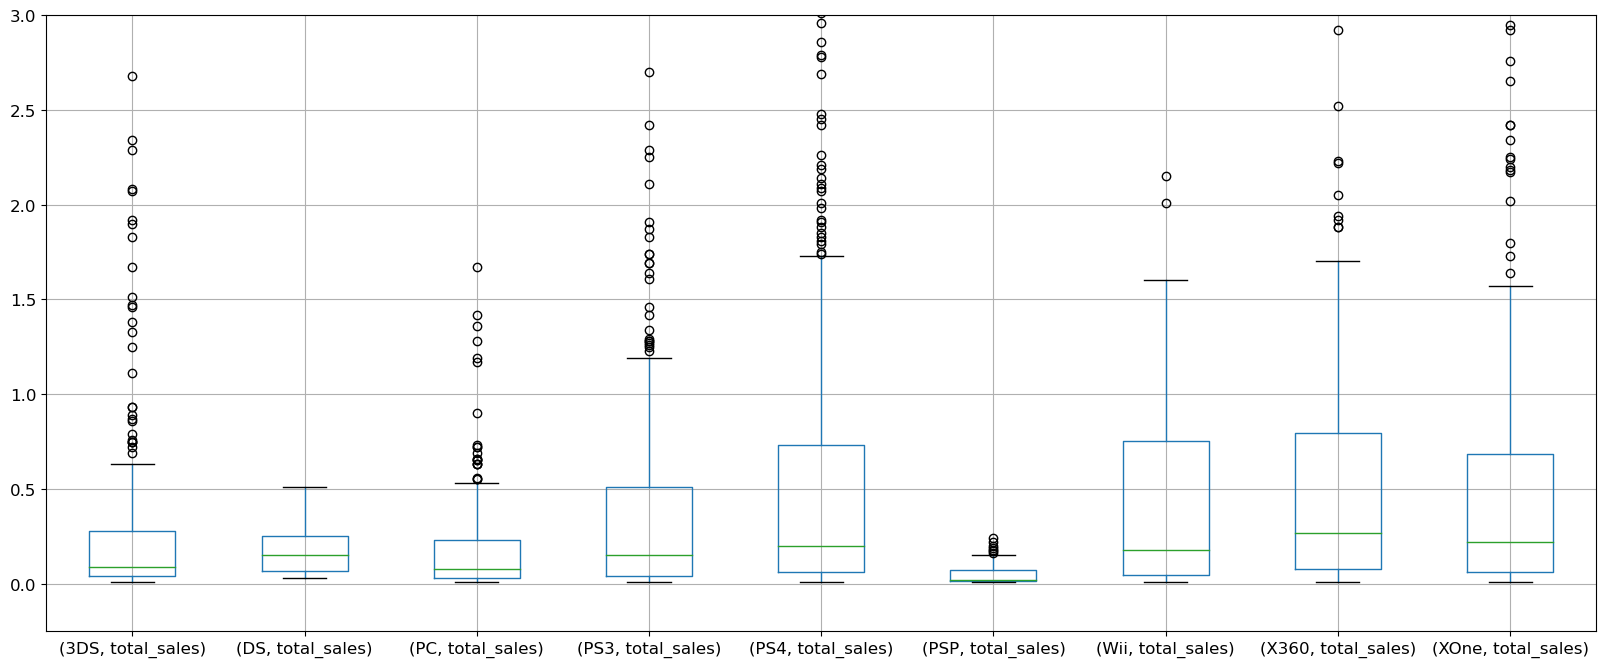

In [62]:
df_now.groupby("platform").boxplot(column="total_sales",subplots=False, figsize=(20,8), fontsize=12, grid=True)
plt.ylim(-0.25, 3); #

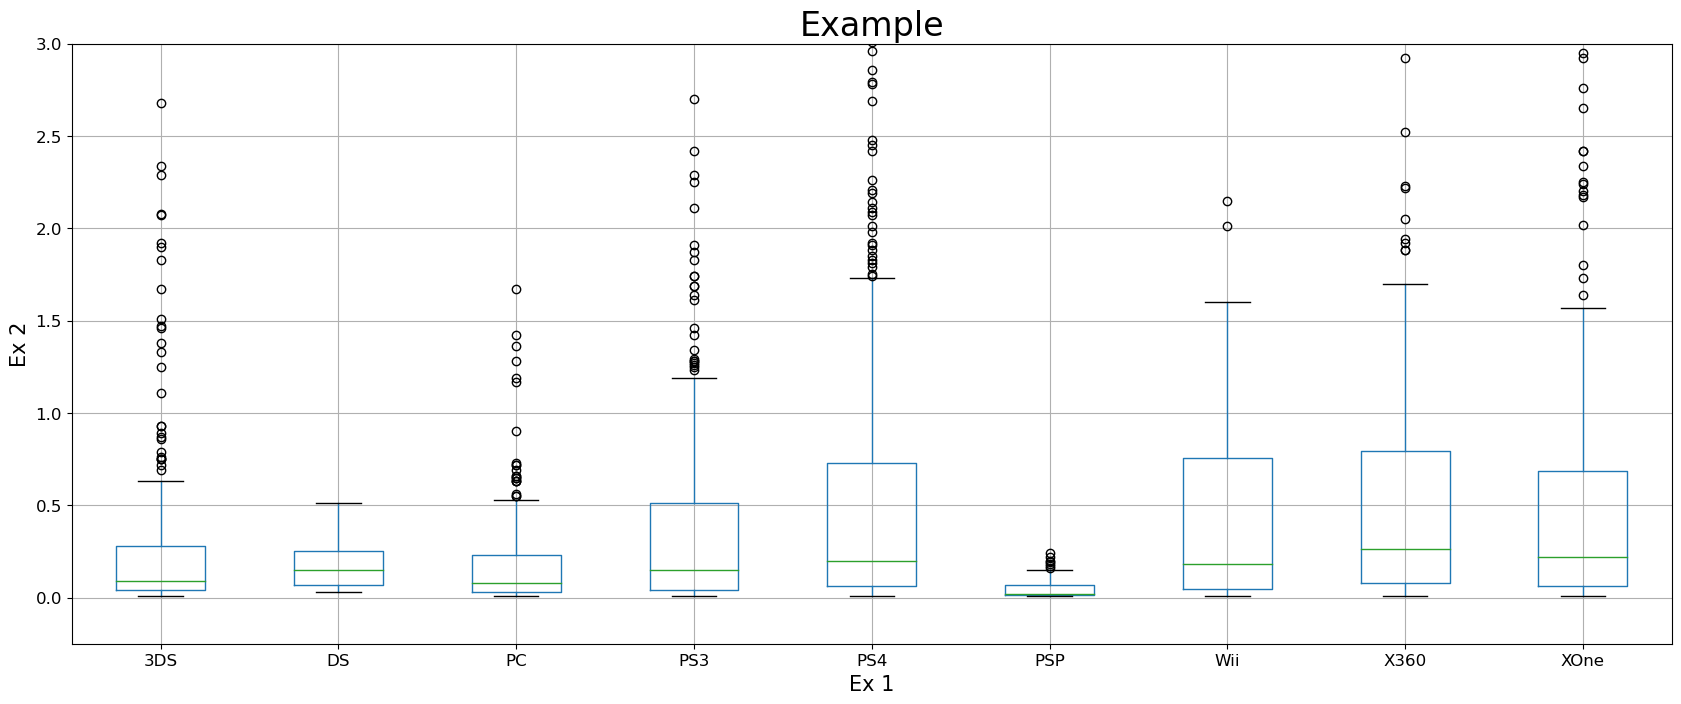

In [63]:
df_now.boxplot(column="total_sales", by = "platform", figsize=(20,8), fontsize=12, grid=True)
plt.ylim(-0.25, 3)
plt.title("Example", fontsize=24)
plt.suptitle("")
plt.xlabel('Ex 1', fontsize=15)
plt.ylabel('Ex 2', fontsize=15); #

## Промежуточный вывод

Данные графика размаха продаж игр на разные платформах подтверждают выводы, сделанные в предыдущих этапах. 

Однако на данном графике видно что на самом деле медианные значения продаж игр на всех платформы отличаются друг от друга не слишком сильно.
- Серия консолей PlayStation продолжает оставаться фаворитом с наибольшим количеством проданных игр.
- Персональные компьютеры, как наибольшие долгожители имеют скромный по сравнению с консолями уровень продаж, однако важно помнить, что данная платформа жива уже более 20 лет.
- Платформа от Microsoft с их консолями серии XBOX чувствует себя уверенно, немного уступая при этом консолям серии PlayStation.
- Консоли серии Wii, 3DS и DS показывают неплохие результаты продаж и также заслуживают внимания игроделов.

Выбросы по суммарным продажам трогать не будет, потому как каждая точка соответствует определенной игре. И скажем GTA 5 может показывать астрономические показатели находясь очень высоко на нашем графике.

In [64]:
platforms_top

platform
PS2     1233.56
X360     961.24
PS3      931.34
Wii      891.18
DS       802.76
PS       721.55
PS4      314.14
GBA      312.88
PSP      289.53
3DS      257.81
XB       251.57
PC       239.79
N64      218.01
GC       196.73
XOne     159.32
Name: total_sales, dtype: float64

In [65]:
# Проанализируем данные самой популярной платформы PS4, построим график рассеивания,
# демонстрирующий влияение оценок пользователй на продажи

df_ps4 = df_now.query('platform == "PS4"')

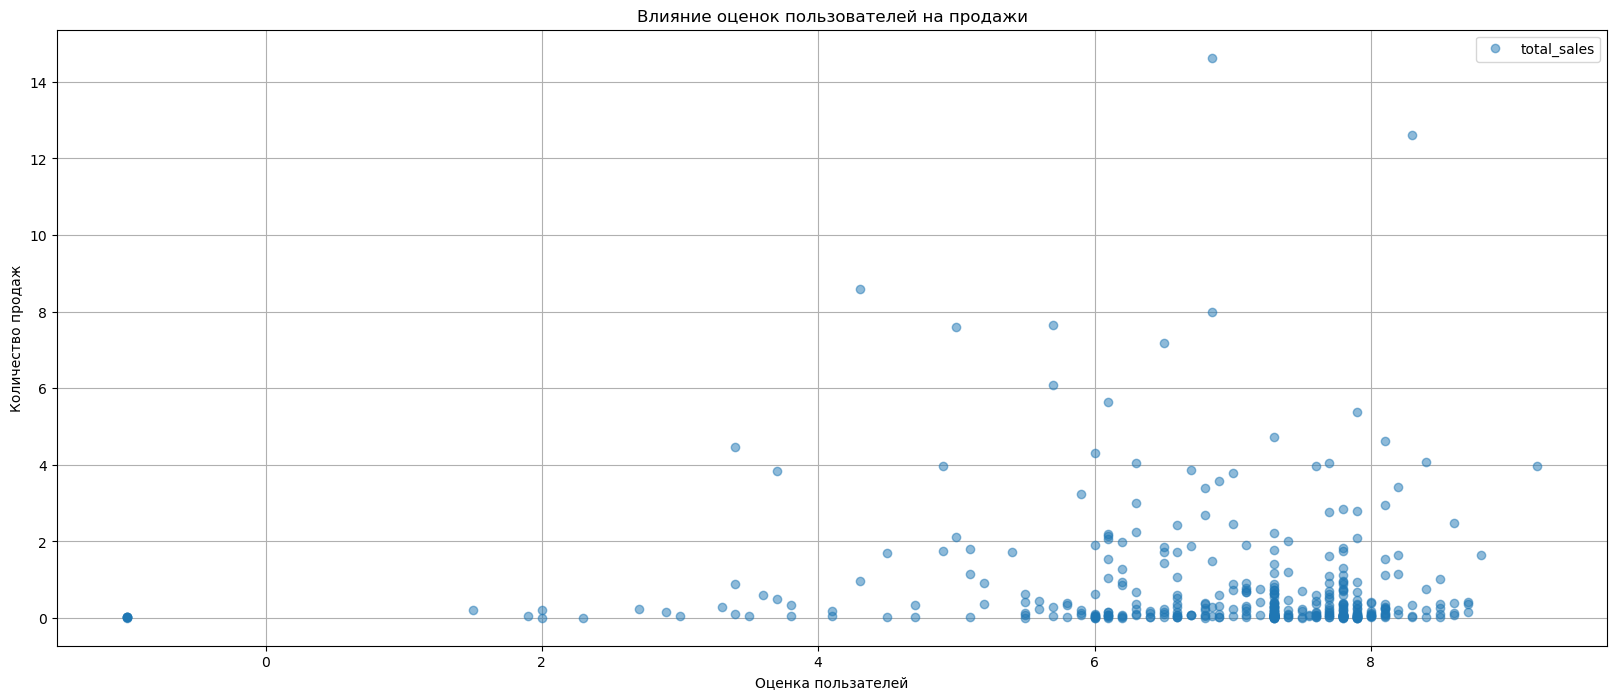

In [66]:
df_ps4.plot(
    kind = 'line',
    x = 'user_score',
    y = 'total_sales',
    figsize = (20,8), 
    style = 'o', 
    alpha = 0.5,
    legend = True, 
    grid = True, 
    title = 'Влияние оценок пользователей на продажи', 
    xlabel = 'Оценка пользателей',
    ylabel = 'Количество продаж',
    );

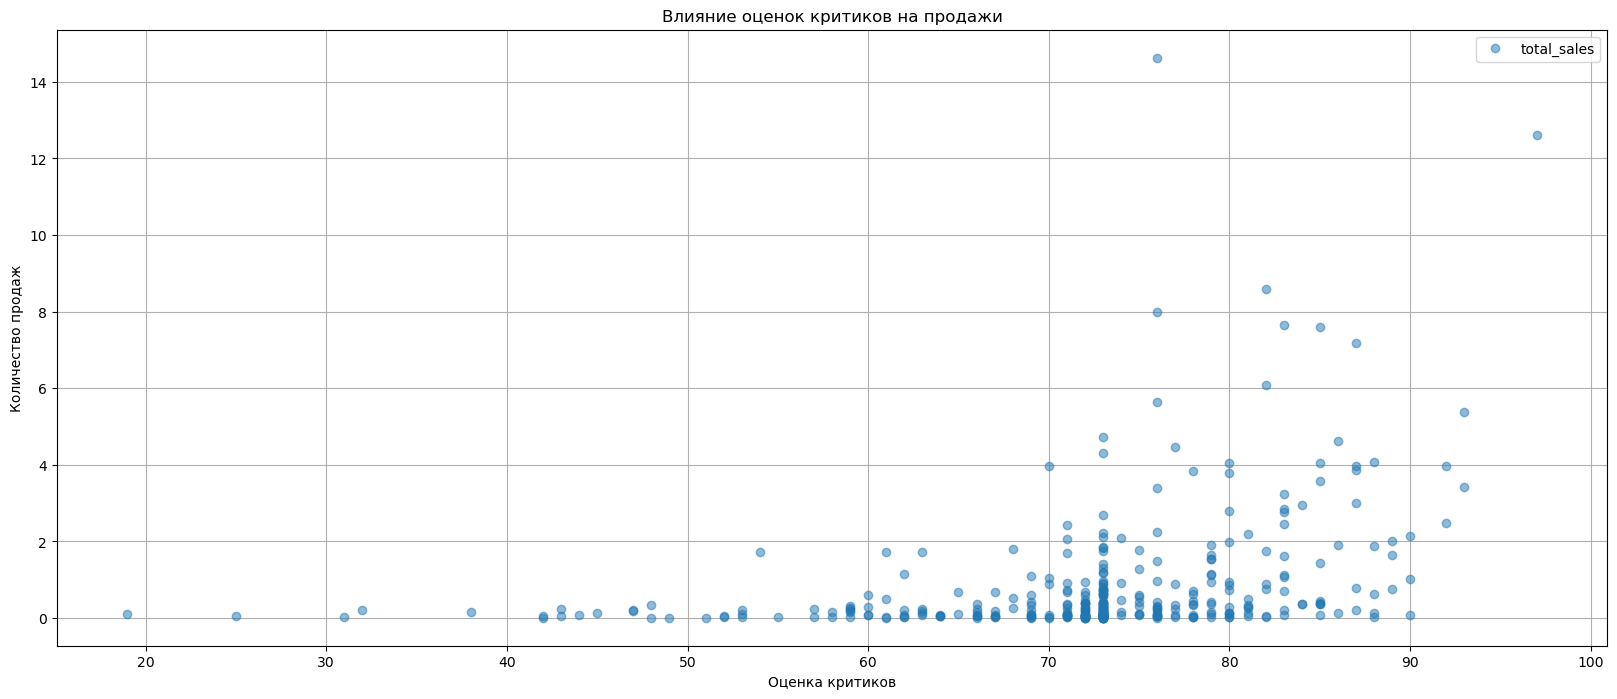

In [67]:
df_ps4.plot(
    kind = 'line',
    x = 'critic_score',
    y = 'total_sales',
    figsize = (20,8), 
    style = 'o', 
    alpha = 0.5,
    legend = True, 
    grid = True, 
    title = 'Влияние оценок критиков на продажи', 
    xlabel = 'Оценка критиков',
    ylabel = 'Количество продаж',
    );

In [68]:
df_ps4[['user_score', 'critic_score', 'total_sales']].corr()

user_score  critic_score  total_sales
user_score      1.000000      0.409070    -0.020146
critic_score    0.409070      1.000000     0.335946
total_sales    -0.020146      0.335946     1.000000

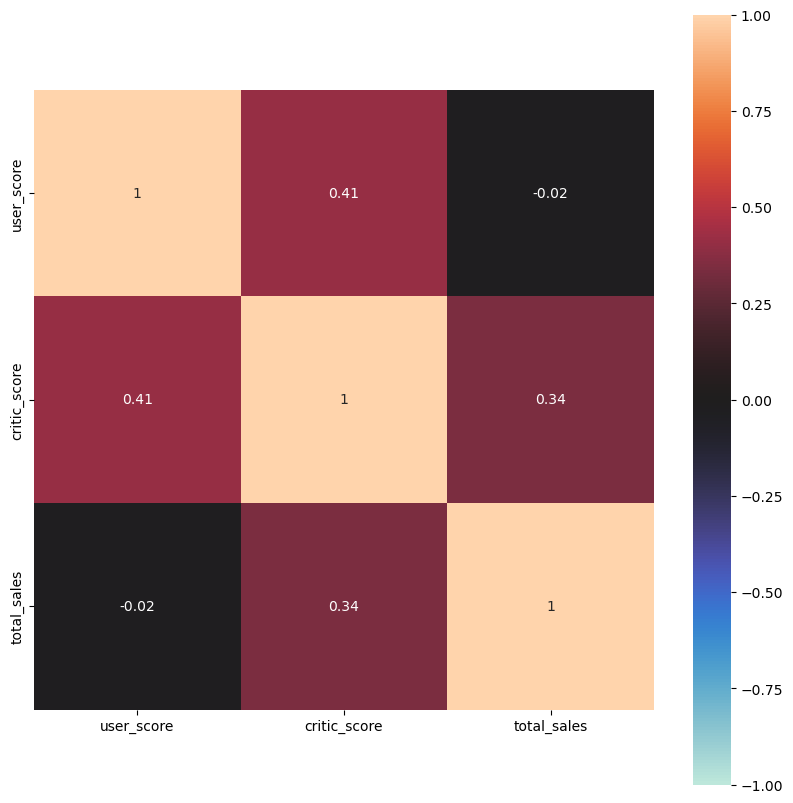

In [69]:
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_ps4[['user_score', 'critic_score', 'total_sales']].corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax);

## Промежуточный вывод

Согласно построенным графикам и посчитанным показателям корреляции можно сказать, что мнение критиков более весомо и сильнее влияет на продажи игр (коэффициент корреляции составляет 0.41), нежели мнение игрового комьюнити(пользователей) (здесь показатель коррелияции 0.34). 

Однака разница не столь существенна и четко видно, что если оценка пользователей низкая, продажи низкие, ровно также влияют и оценки критиков на данный показатель

Продолжим анализировать данные и посмотрим распостраняется ли эта тенденция на все платформы.

In [70]:
# посмотрим для остальных платформ

df_slice = df_now.query('platform in @platforms_top.index')[['platform', 'user_score', 'critic_score', 'total_sales']]

df_result = pd.DataFrame(data=[], index=['user_score', 'critic_score'], columns=[])

for platform in df['platform'].unique():
    df_slice_platform = df_slice.query('platform == @platform')
    user_score_corr = df_slice_platform['user_score'].corr(df_slice_platform['total_sales'])
    critic_score_corr = df_slice_platform['critic_score'].corr(df_slice_platform['total_sales'])
    df_result[platform] = [user_score_corr, critic_score_corr]

df_result.dropna(axis='columns', inplace=True)
# посмотрим, что получилось
df_result

Wii        DS      X360       PS3       PS4       3DS  \
user_score    0.539165  0.905948  0.031441  0.042952 -0.020146  0.168248   
critic_score  0.102335  0.223459  0.302873  0.282109  0.335946  0.201768   

                    PC       PSP      XOne  
user_score   -0.033213 -0.219636  0.053884  
critic_score  0.173881  0.456359  0.331727

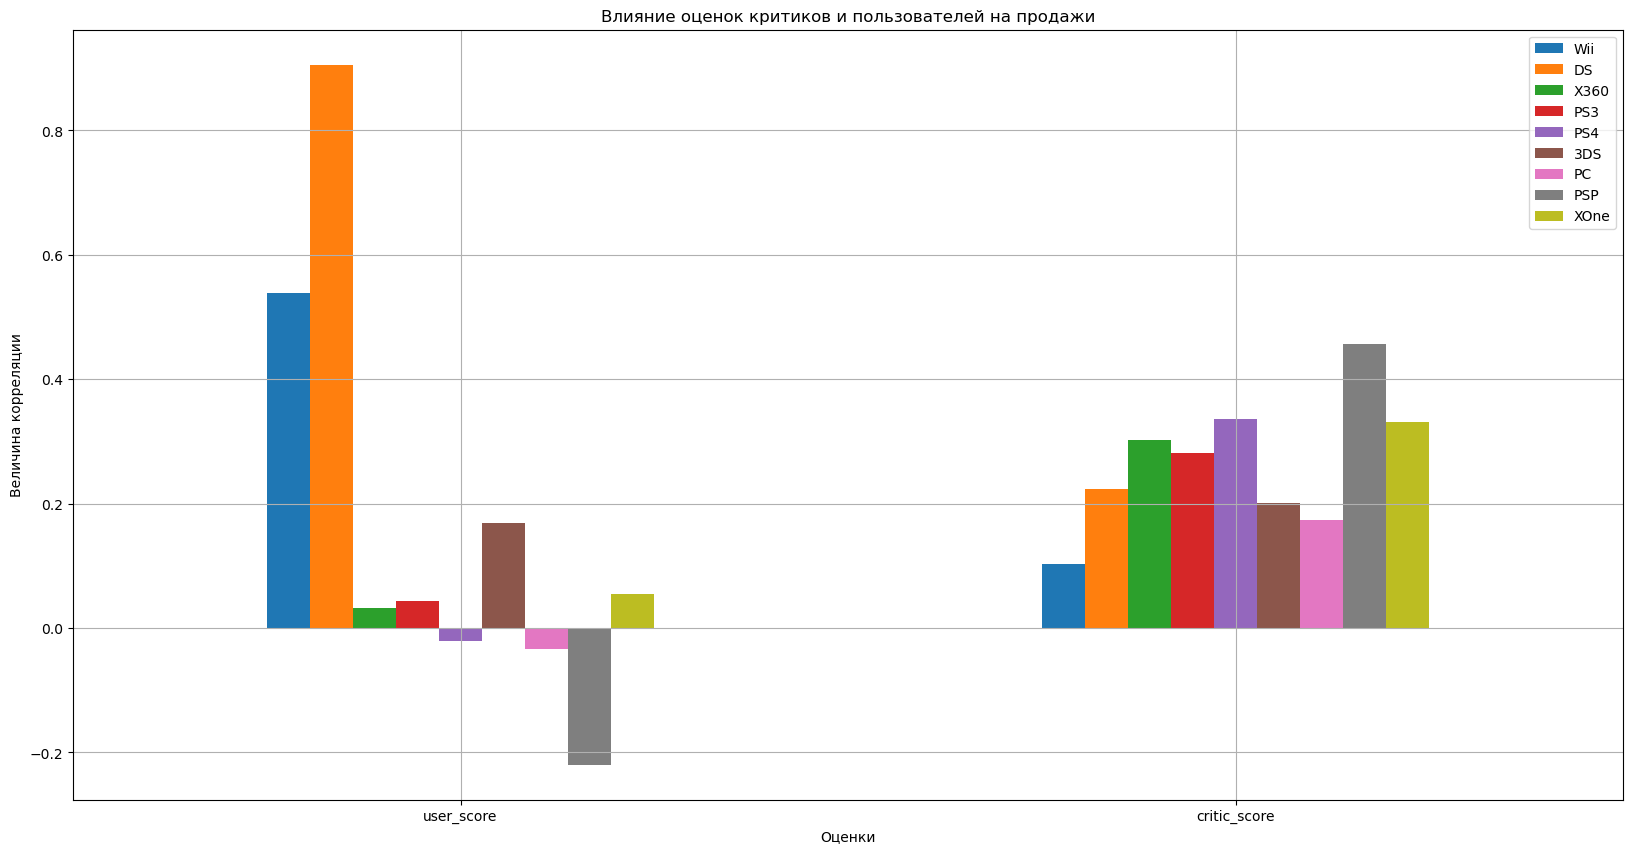

In [71]:
df_result.plot(
    kind='bar',
    figsize = (20,10), 
    legend = True, 
    grid = True, 
    title = 'Влияние оценок критиков и пользователей на продажи', 
    xlabel = 'Оценки',
    ylabel = 'Величина корреляции',
    rot = 0
);

## Промежуточный вывод

Изученные данные о корреляции оценок пользователей и критиков на количество продаж показали, что ситуация с таким влияние довольно неоднородна. Это больше всего ощущается при оценки корреляции именно пользовательских оценок.
- На общем фоне очень сильно выделяются данные по двум платформам `Wii`, `DS`. Их можно назвать неадекватными, скорее всего в такого рода корреляции оценок с количеством продаж фигурируют иные признаки. (нам неизвестные)

В общем, не считая эти два отклонения можно сделать вывод, что мнение пользователей очень незначительно коррелирует с количеством продаж игры или не коррелирует вовсе, чего нельзя сказать про мнение критиков.

*В целом, общая тенденция для любой платформы схожа - оценки игроков имеют крайне слабую корреляцию, а вот оценки критиков - более ощутимую. Чем выше оценка критиков - тем больше продажи.*

Однако скорее всего данная корреляция, что в случае с мнением критиков, что пользователей является ложной. Этот вывод напрашивается из-за ограниченности имеющихся данных и того факта, что независимо от оценки количество продаж может быть как высоким, так и очень низким.

Единственное, что действительно можно сказать проведя данную часть анализа, что если игра хорошо продается, то её оценка будет высокой, как у критиков, так и у пользователей.

In [72]:
df_now['genre'].value_counts()

Action          593
Role-Playing    209
Sports          192
Shooter         177
Adventure       156
Misc            118
Racing           80
Fighting         66
Simulation       58
Platform         53
Strategy         47
Puzzle           11
Name: genre, dtype: int64

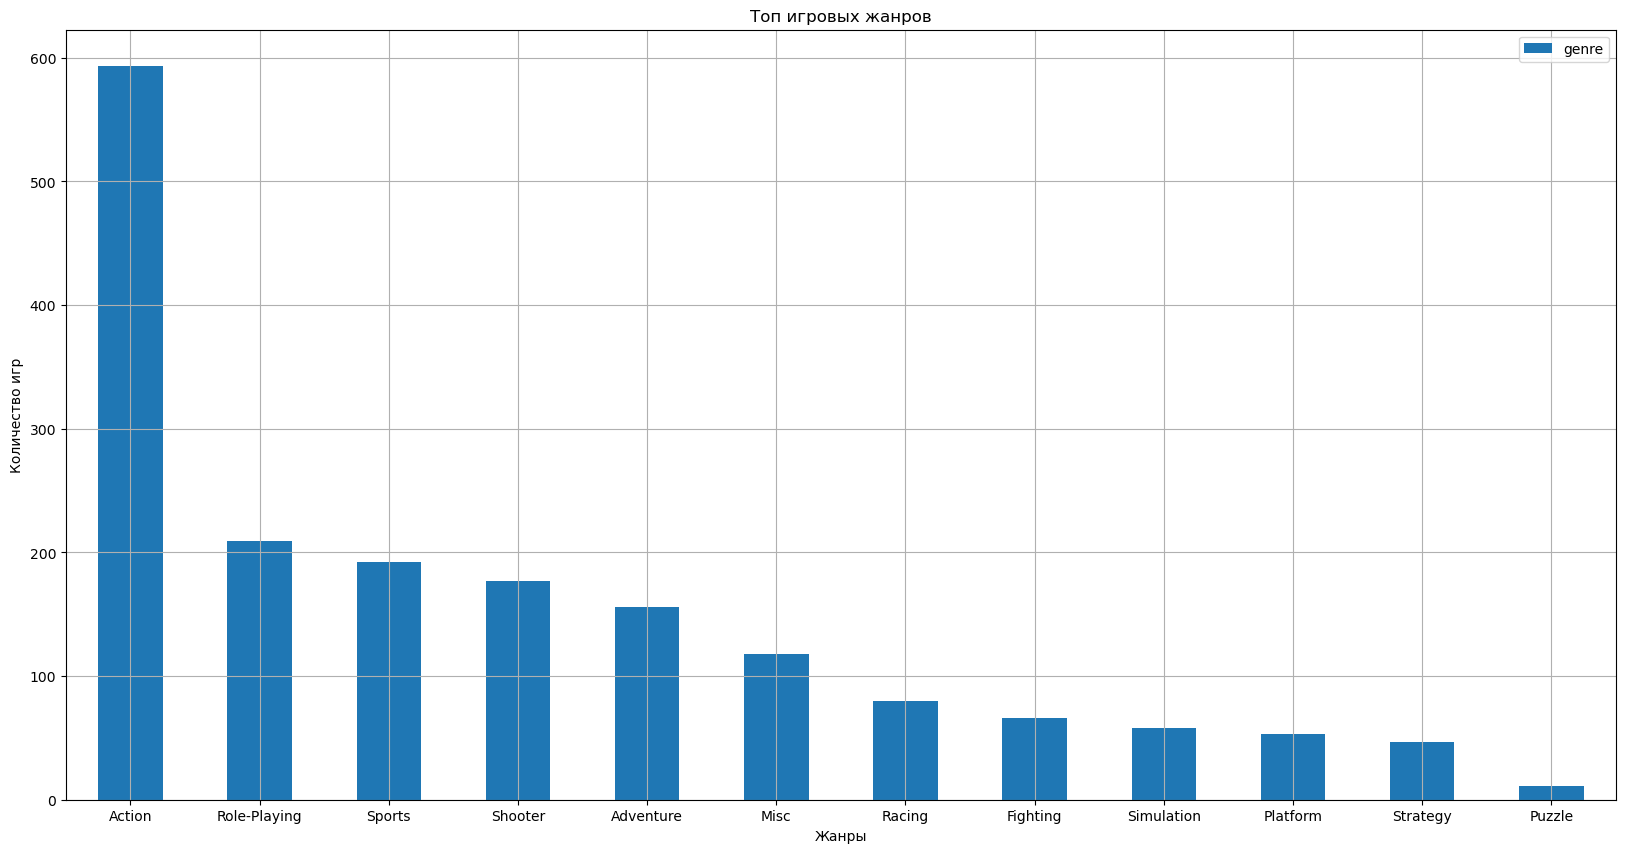

In [73]:
df_now['genre'].value_counts().plot.bar(
    #kind='bar',
    figsize = (20,10), 
    legend = True, 
    grid = True, 
    title = 'Топ игровых жанров', 
    xlabel = 'Жанры',
    ylabel = 'Количество игр',
    rot = 0,
);

In [74]:
genre_sales = df_now.pivot_table(index='genre',values='total_sales', aggfunc='mean')
genre_sales = genre_sales.sort_values(by = 'total_sales',ascending = False)
genre_sales

total_sales
genre                    
Shooter          1.277175
Sports           0.760990
Role-Playing     0.639856
Action           0.501518
Platform         0.488491
Misc             0.437203
Fighting         0.424697
Racing           0.405375
Simulation       0.370862
Strategy         0.181064
Puzzle           0.162727
Adventure        0.128333

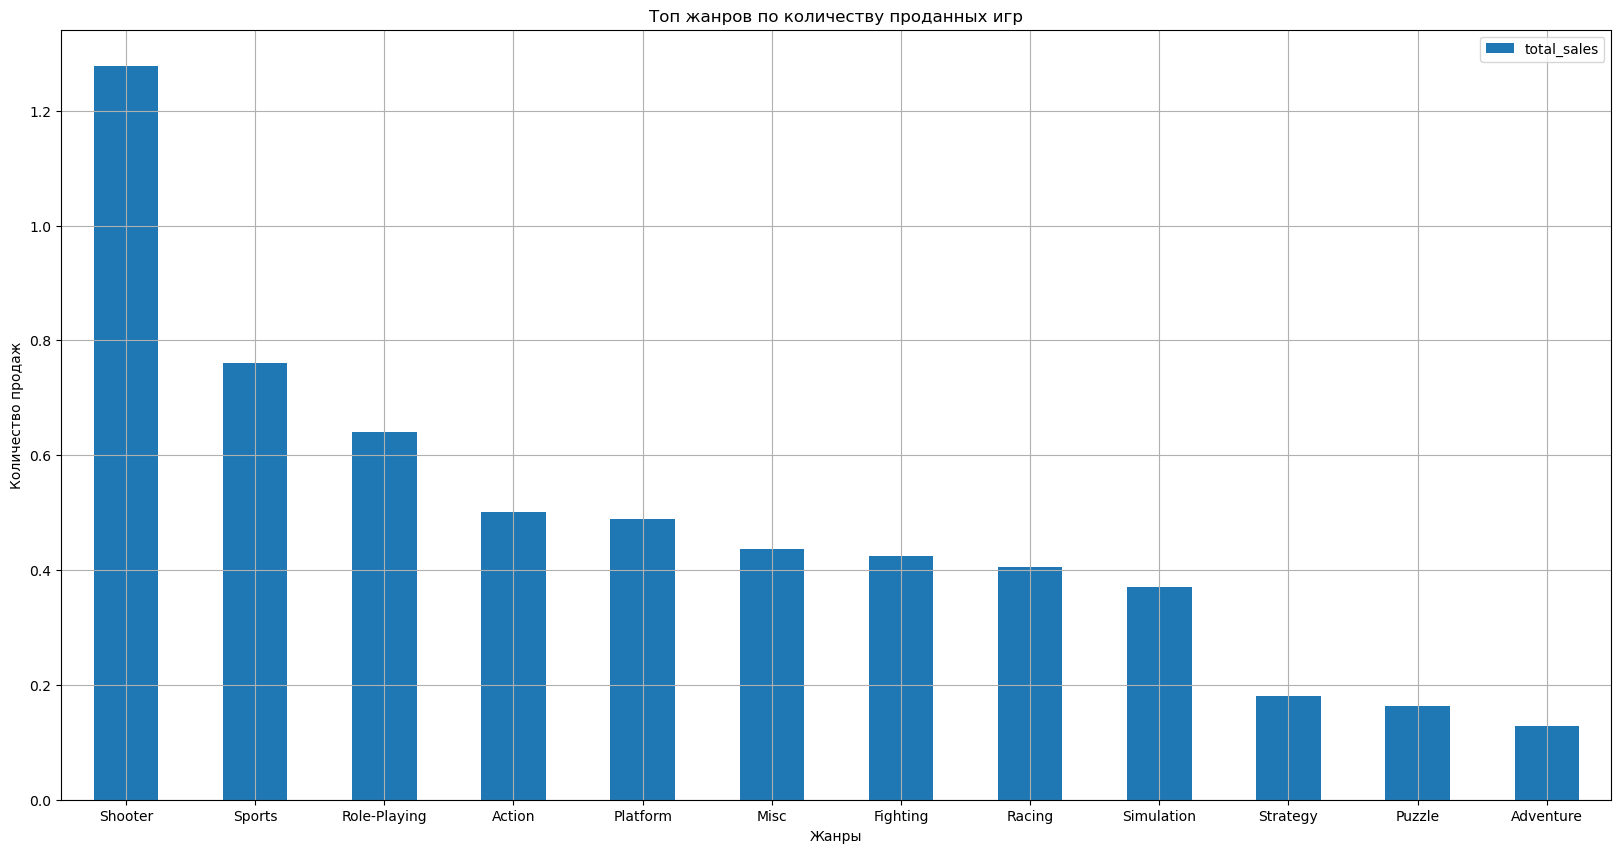

In [75]:
genre_sales.plot(
    kind='bar',
    figsize = (20,10), 
    legend = True, 
    grid = True, 
    title = 'Топ жанров по количеству проданных игр', 
    xlabel = 'Жанры',
    ylabel = 'Количество продаж',
    rot = 0
);

## Промежуточный вывод

- Игроделы больше всего создали игр в жанре `Action`, далее их интерес к созданию игр резко проваливается и следом идут все остальные жанры игр.
- Несмотря на столь большое количество игр в `Action` наиболее комерчески успешными они не являются, не попадая в тройку лидеров. 
- Тройка лидеров по этому показателю закрепилась за следующими жанрами: `Shotter`, `Sports`, `Role-Playing`, после них 6 жанров показывают схожие показали по продажам игр в районе 0.4.
- Внезапно довольно распостраненный жанр игр `Adventure` занимающих 5 место по количеству созданных игр продается хуже всех с показателем менее 0.2.

# Сопоставление пользователей

In [76]:
def make_df_bar(data,index,value):
    df_na =(data
     .groupby(index)[value[0]]
     .sum()
     .reset_index()
     .sort_values(by=value[0], ascending=False)
     .head(5)
    )
    df_jp =(data
     .groupby(index)[value[1]]
     .sum()
     .reset_index()
     .sort_values(by=value[1], ascending=False)
     .head(5)
    )
    df_eu =(data
     .groupby(index)[value[2]]
     .sum()
     .reset_index()
     .sort_values(by=value[2], ascending=False)
     .head(5)
    )
    
    df_regions = df_na.merge(df_jp, how='outer', on=index)
    df_regions = df_regions.merge(df_eu, how='outer', on=index)
    
    return df_regions

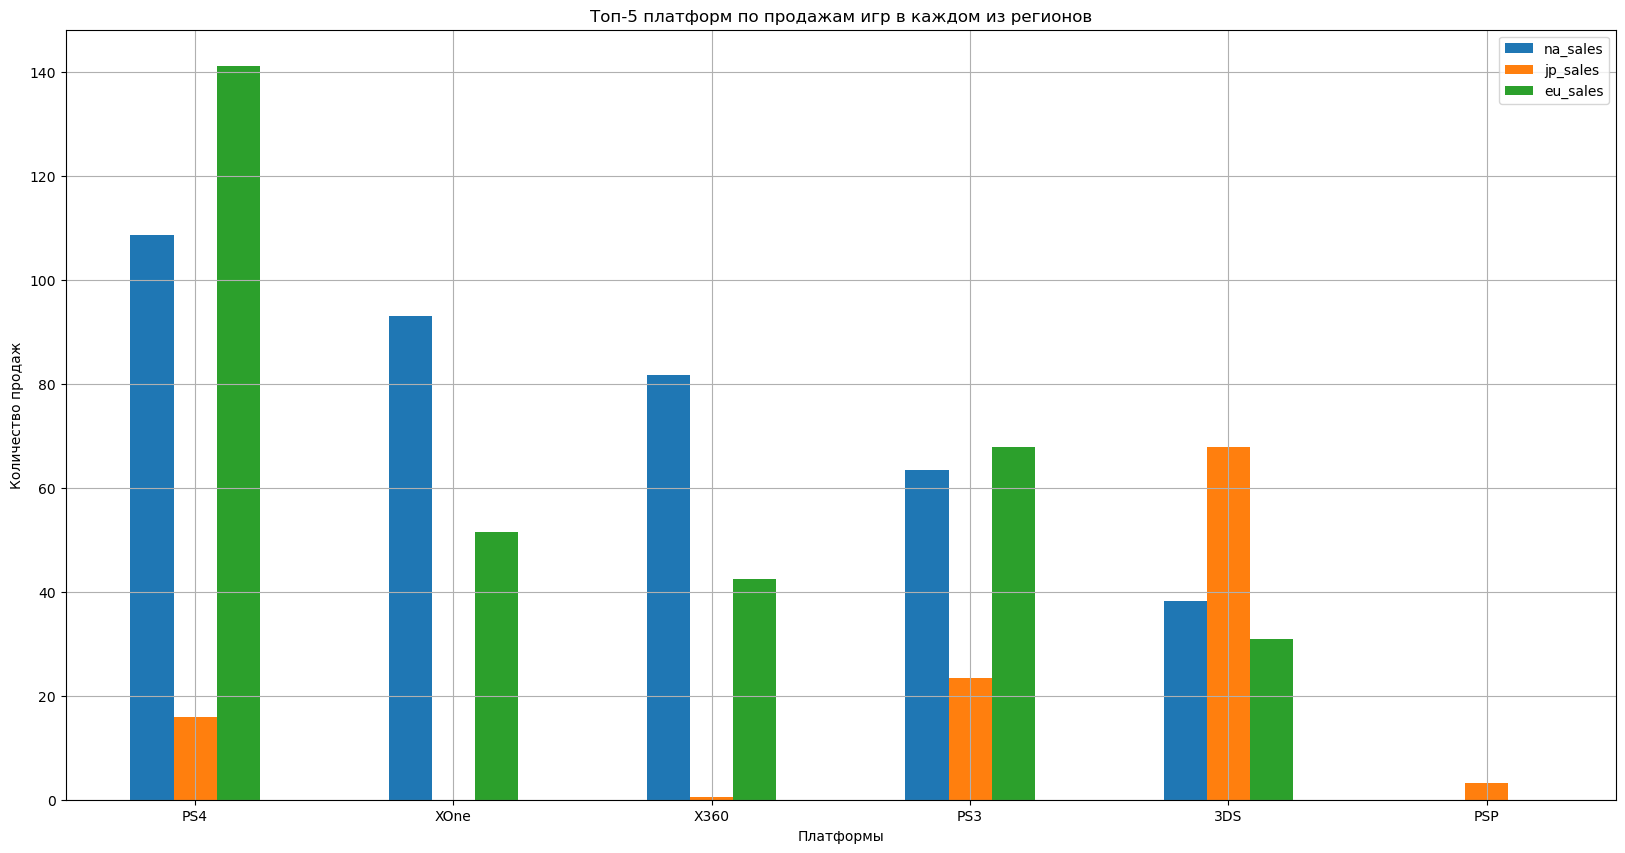

In [77]:
make_df_bar(df_now,'platform',['na_sales','jp_sales','eu_sales']).plot(
    kind='bar',
    x = 'platform',
    figsize = (20,10), 
    legend = True, 
    grid = True, 
    title = 'Топ-5 платформ по продажам игр в каждом из регионов', 
    xlabel = 'Платформы',
    ylabel = 'Количество продаж',
    rot = 0
);

## Промежуточный вывод
- В Северной Америке и Европе самой популярной платформой является `PS4`, в Японии `3DS`.
- Сравнивая регионы между собой Северная Америка приносит больше всего денег, Япония меньше всего.
- Япония сильно отличается по количеству покупаемых игр и по платформам на которых они это делают, выводя в топы своего рынка Нинендо и не отказываясь от старой PlayStation3


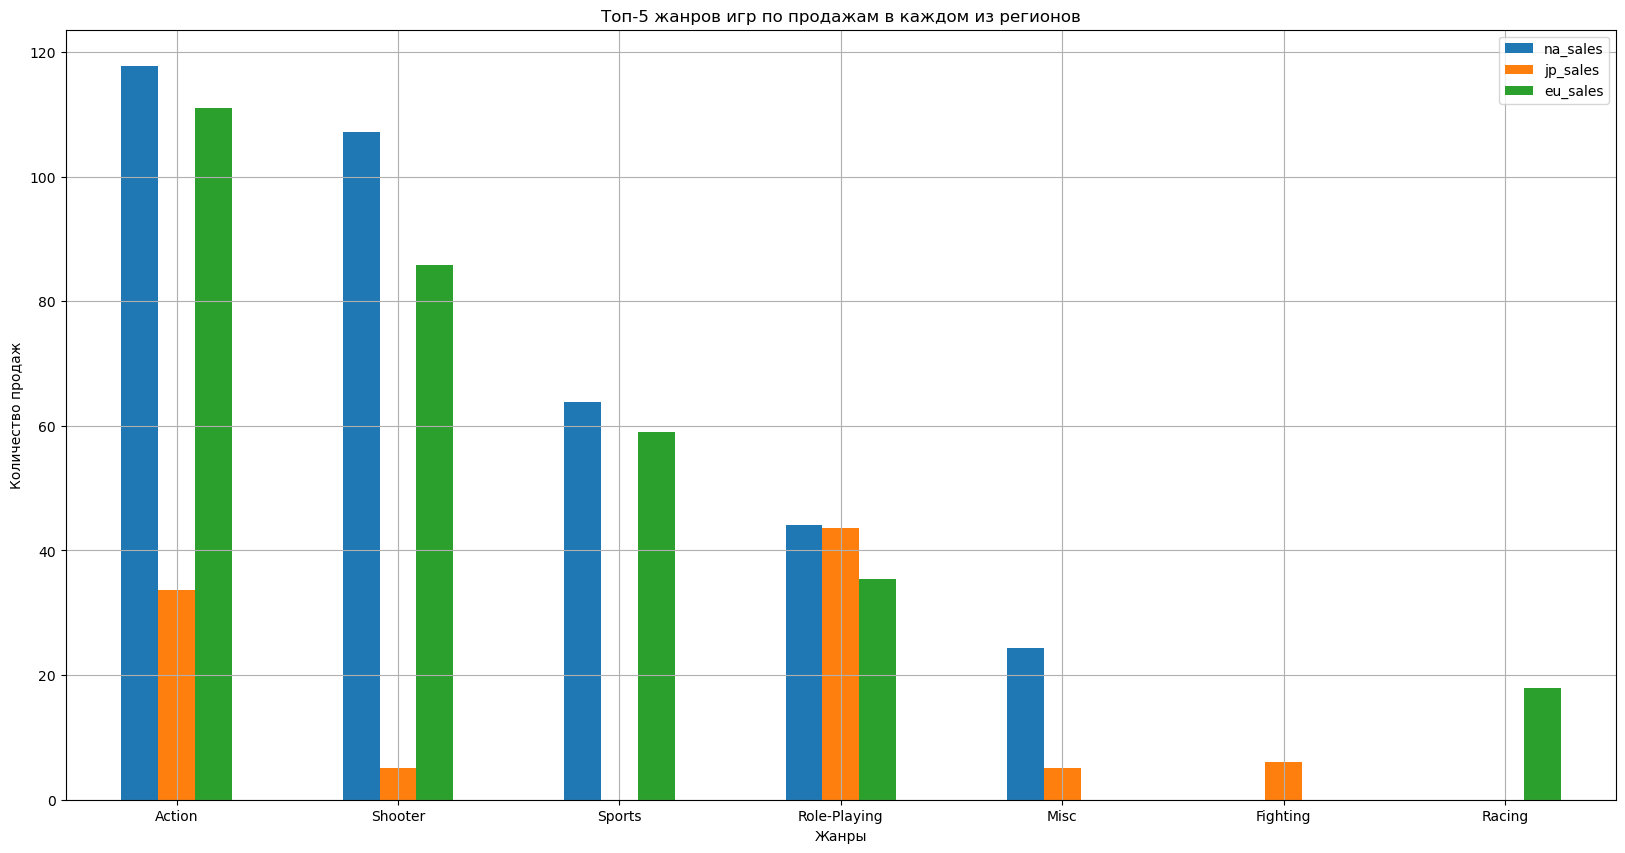

In [78]:
make_df_bar(df_now,'genre',['na_sales','jp_sales','eu_sales']).plot(
    kind='bar',
    x = 'genre',
    figsize = (20,10), 
    legend = True, 
    grid = True, 
    title = 'Топ-5 жанров игр по продажам в каждом из регионов', 
    xlabel = 'Жанры',
    ylabel = 'Количество продаж',
    rot = 0
);

## Промежуточный вывод
- В Японии больше всего ценят ролевые игры
- Предпочтения в Америке и Европе, в целом, схожи и отдаются играм жанра `Action` и `Shooter` 
- В целом, самым популярным жанром для любого региона можно считать `Action`
- Спортивные игры и шутеры не отстают, но, что любопытно, Япония опять выделяется - там шутеры ценят не особо.
- В Европе в отличии от всех других регионов любят поиграть в гонки.


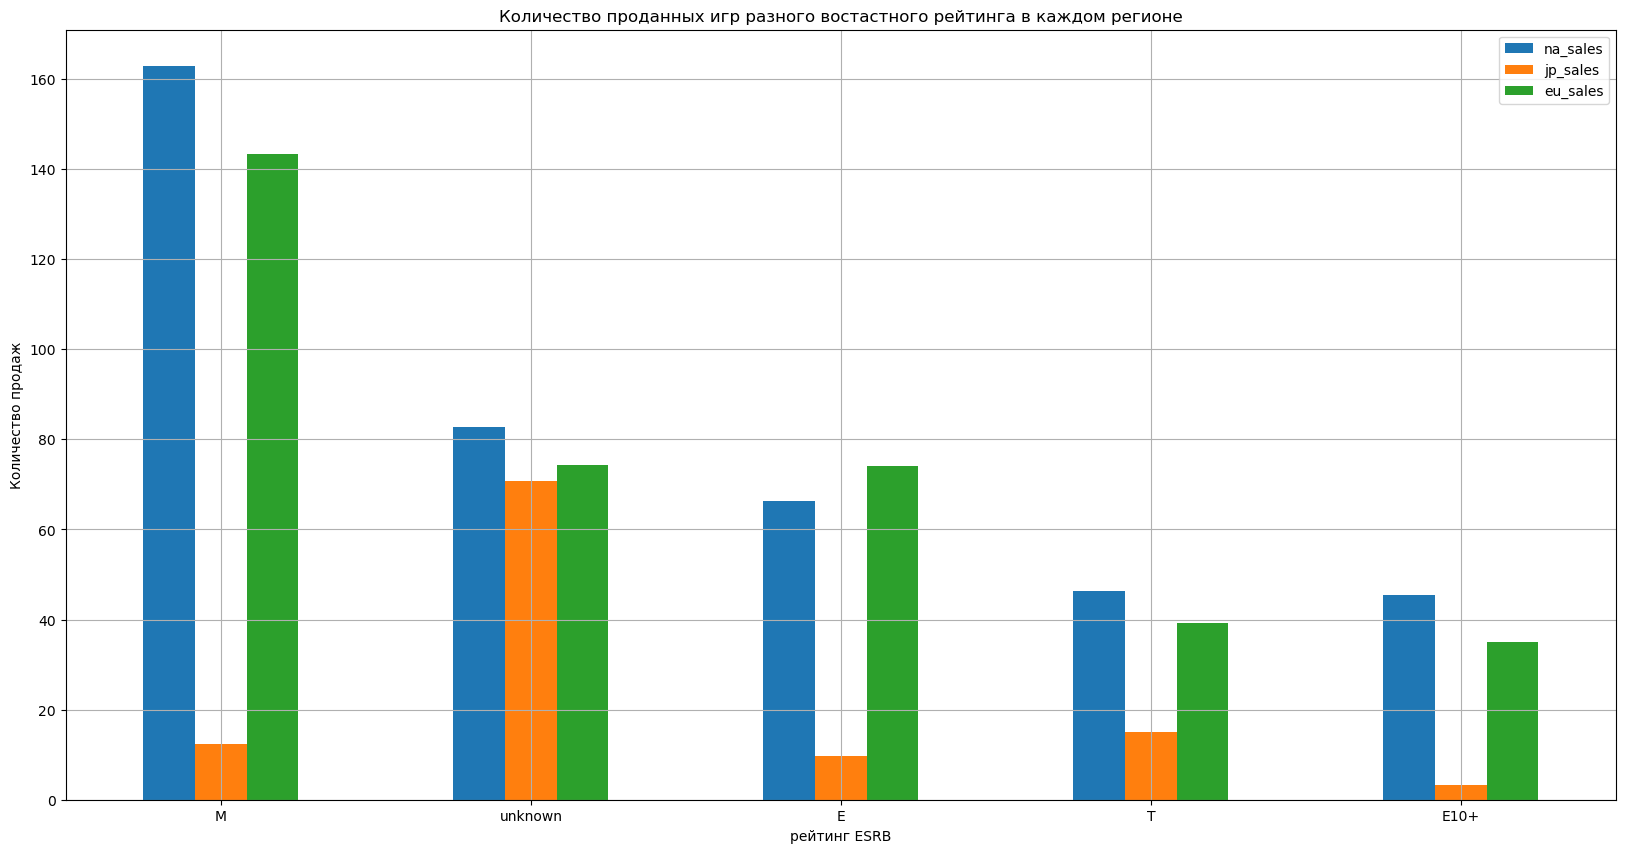

In [79]:
make_df_bar(df_now,'rating',['na_sales','jp_sales','eu_sales']).plot(
    kind='bar',
    x = 'rating',
    figsize = (20,10), 
    legend = True, 
    grid = True, 
    title = 'Количество проданных игр разного востастного рейтинга в каждом регионе', 
    xlabel = 'рейтинг ESRB',
    ylabel = 'Количество продаж',
    rot = 0
);

In [80]:
def rating_to_number(value):
    rating_dict = dict()
    rating_dict['E'] = 0
    rating_dict['E10+'] = 1
    rating_dict['T'] = 2
    rating_dict['M'] = 3
    rating_dict['unknown'] = 4
  
    return rating_dict[value]

C:\Users\kiril\AppData\Local\Temp\ipykernel_6200\1113892863.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rating_corr1['rating_category'] = df_rating_corr1['rating'].apply(rating_to_number)


<AxesSubplot:>

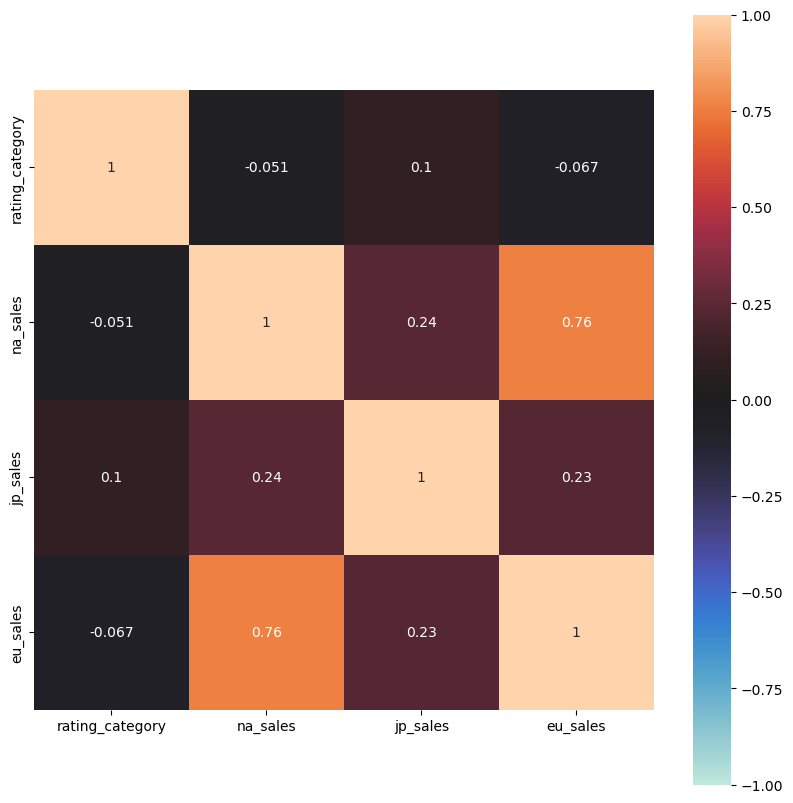

In [81]:
df_rating_corr1 = df_now
df_rating_corr1['rating_category'] = df_rating_corr1['rating'].apply(rating_to_number)


df_rating_corr1[['rating_category','na_sales','jp_sales','eu_sales']].corr()

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(df_rating_corr1[['rating_category','na_sales','jp_sales','eu_sales']].corr(), annot=True, square=True, vmin=-1, vmax=1, center=0, ax=ax)

In [82]:
# check
# круги + категория другие
def graph (df, year, region, name, axes):
    
    df = df.query('year_of_release >= @year')
    
    sales = df.pivot_table(index='rating', 
                           values=region, 
                           aggfunc='sum').nlargest(5, region)
    
    sales = sales.reset_index()  
    sales.columns = ['rating', 'sales']
      
    labels_c=sales.rating
    colours = {'E': 'C0', 'E10+': 'C1', 'T': 'C2', 'M': 'C3', 'unknown': 'C4'}#, 'Other':'red'}
    
      
    sales.plot(kind='pie',
               y="sales",
               autopct='%1.0f%%',
               wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
               textprops={'size': 'x-large'}, 
               labels= labels_c,
               colors=[colours[key] for key in labels_c],
               legend=False, 
               title = f"Распределение рейтингов в {name} ", 
               ax = axes).set(ylabel='')
    
    plt.tight_layout()

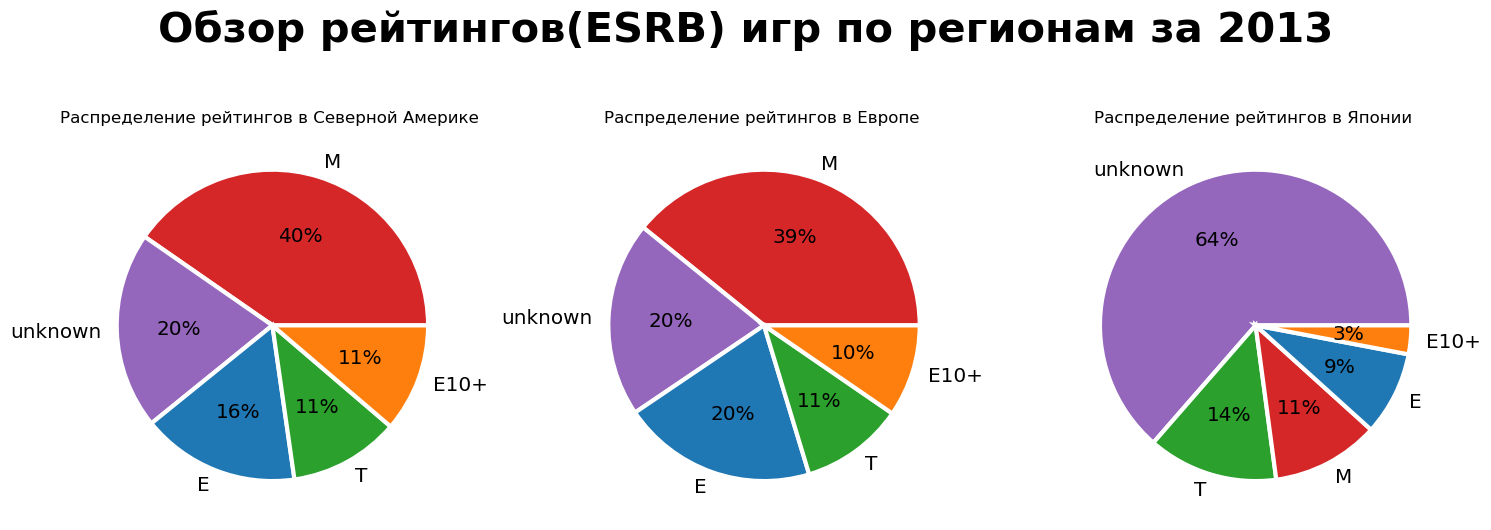

In [83]:
# check
# круги в ряд
x_year = 2013

fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle(f'Обзор рейтингов(ESRB) игр по регионам за {x_year}', fontsize = 30, fontweight='bold')

graph(df_now, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(df_now, x_year,'eu_sales', 'Европе', axes[1])
graph(df_now, x_year, 'jp_sales', 'Японии', axes[2])

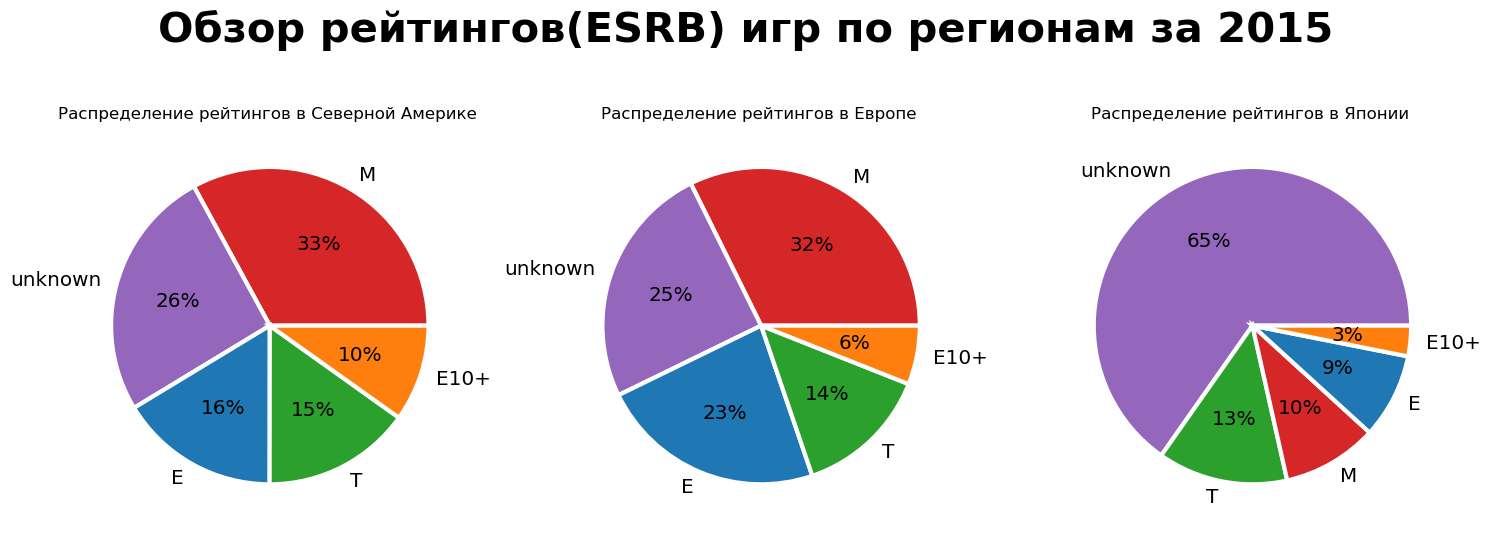

In [84]:
# check
# круги в ряд
x_year = 2015

fig, axes = plt.subplots(1, 3, figsize = (15,6))
fig.suptitle(f'Обзор рейтингов(ESRB) игр по регионам за {x_year}', fontsize = 30, fontweight='bold')

graph(df_now, x_year, 'na_sales', 'Северной Америке', axes[0])
graph(df_now, x_year,'eu_sales', 'Европе', axes[1])
graph(df_now, x_year, 'jp_sales', 'Японии', axes[2])

## Промежуточный вывод

Поскольку мы присваивали числовые значения рейтингу не просто так, а исходили из того, что чем число выше, тем рейтинг старше, то можно сказать следующее:

Хоть сколько значимая корреляция рейтинга игры и количество реализованных копий не выявлено, ни в одном регионе.

Однако интересно другое, распределение рейтингов в каждом из регионов явно дает нам понять, что регионы Северной Америки и Европы крайне схожи(почти идентичны) в своих предпочтениях и процент игр не получивших рейтинг составляет 20%-26% в зависимости от года.

Япония существует обособленно. Процент игр не получивших рейтинг превышает показатель двух других регионов более чем в три раза и составляет 64%. Этот показатель говорит нам, что Японцы при создании игр зачастую не нацелены на мировой рынок, а создаются для локального пользователя, которому будет все равно какой рейтинг по верии ESRB ей присвоен.


# Проверка гипотез

## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем гипотизы H0 и H1

- **Гипотеза H0**: Средние пользовательские рейтинги платформ Xbox One и PC равны;
- **Гипотеза H0**: Средние пользовательские рейтинги платформ Xbox One и PC отличаются;

In [85]:
H0 = 'Не можем отвергнуть гипотизу - средние пользовательские рейтинги платформ Xbox One и PC равны'
H1 = 'Отвергаем нулевую гипотезу, средние пользовательские рейтинги платформ Xbox One и PC различаются'

In [86]:
alpha = 0.05 # 5% - достаточный уровень значимости, большая точность нам не нужна.

df_xbox_one = df_now.query('platform == "XOne"')
df_pc = df_now.query('platform == "PC"')

<AxesSubplot:>

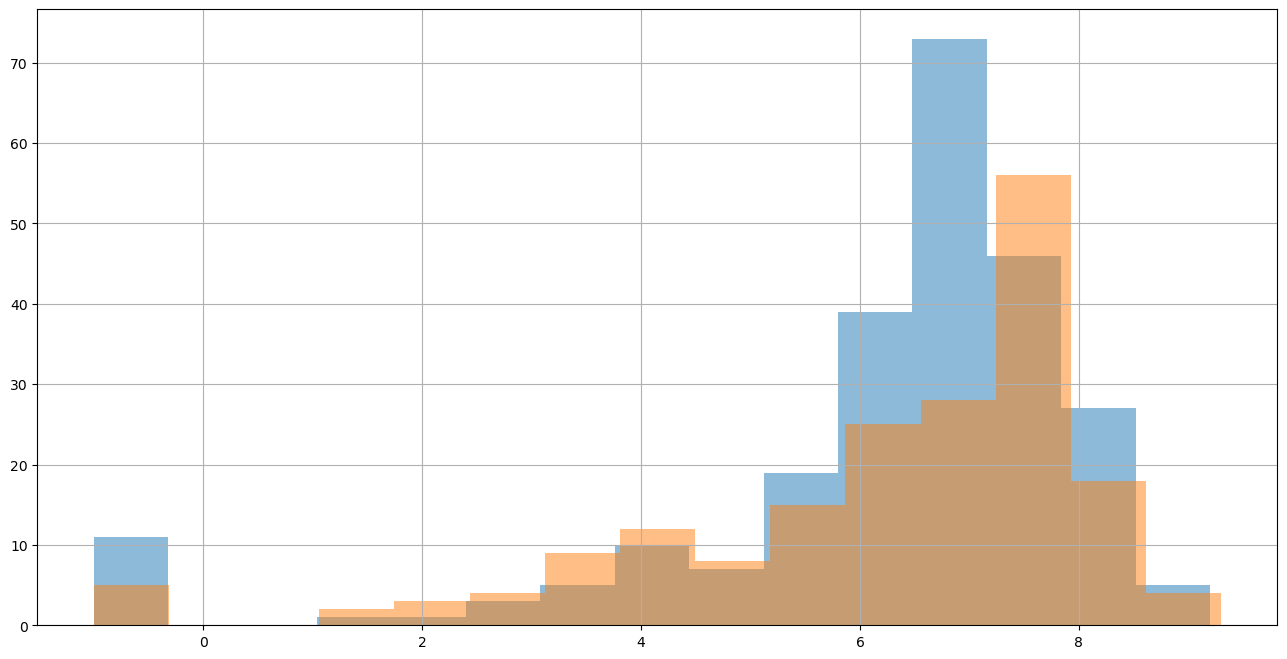

In [87]:
df_xbox_one['user_score'].hist(bins=15,alpha=0.5, figsize=(16,8))
df_pc['user_score'].hist(bins=15,alpha=0.5, figsize=(16,8))

In [88]:
results = st.ttest_ind(df_xbox_one['user_score'], df_pc['user_score'], equal_var = False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print(H1)
else:
    print(H0)

p-значение: 0.9511481424931229
Не можем отвергнуть гипотизу - средние пользовательские рейтинги платформ Xbox One и PC равны


In [89]:
print('XBOX mean = ', df_xbox_one['user_score'].mean())
print('PC mean = ', df_pc['user_score'].mean())

XBOX mean =  6.235222672064769
PC mean =  6.223280423280421


In [90]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:

    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


## Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Сформулируем гипотизы H0 и H1

- **Гипотеза H0**:  Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») одинаковые.;
- **Гипотеза H1**: Средние пользовательские рейтинги жанров Action и Sports разные.

In [91]:
H0 = 'Не можем отвергнуть гипотизу - cредние пользовательские рейтинги жанров Action и Sports равны'
H1 = 'Отвергаем нулевую гипотезу, cредние пользовательские рейтинги жанров Action и Sports различаются'

df_action = df_now.query('genre == "Action"')
df_sports = df_now.query('genre == "Sports"')

<AxesSubplot:>

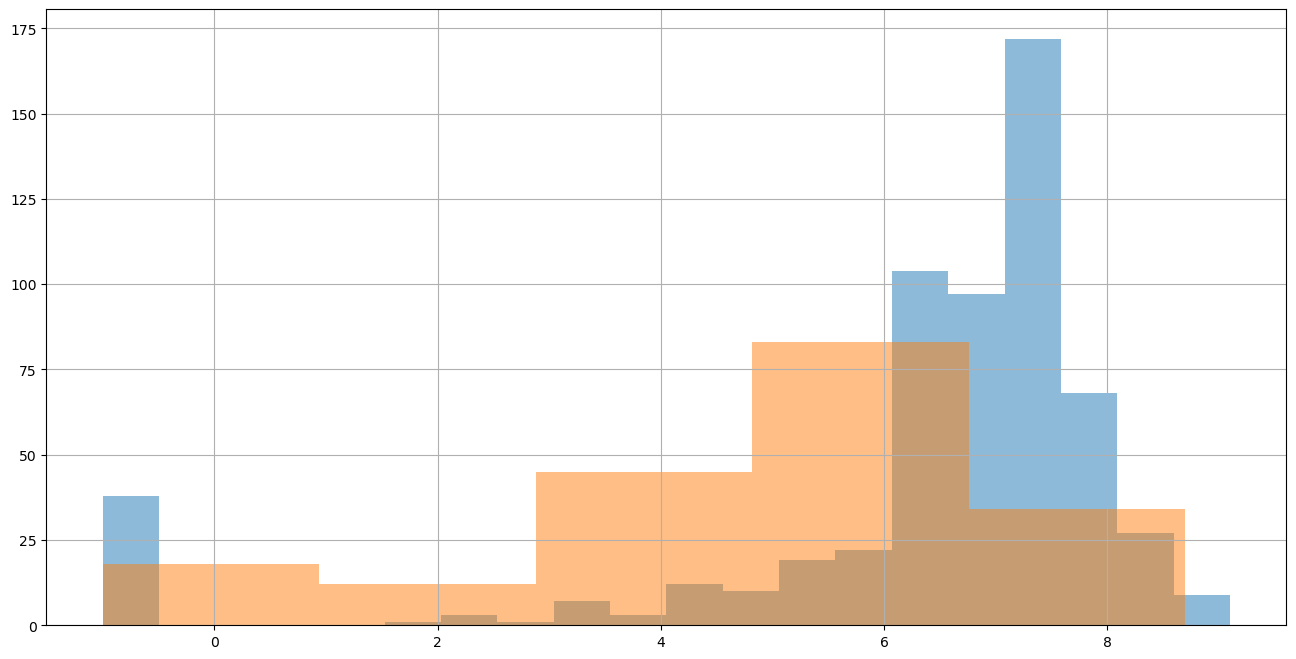

In [92]:
# Посмотрим на распределение оценок
df_action['user_score'].hist(bins=20, alpha=0.5, figsize=(16,8))
df_sports['user_score'].hist(bins=5, alpha=0.5, figsize=(16,8))

In [93]:
results = st.ttest_ind(df_action['user_score'], df_sports['user_score'], equal_var = False)

print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print(H1)
else:
    print(H0)

p-значение: 1.0272994002315138e-12
Отвергаем нулевую гипотезу, cредние пользовательские рейтинги жанров Action и Sports различаются


In [94]:
#Посмотрим средние оценки
print('Action mean = ', df_action['user_score'].mean())
print('Sports mean = ', df_sports['user_score'].mean())

Action mean =  6.27664418212479
Sports mean =  4.83645833333333


# Общий вывод

1. Была проведена подготовка и первичных анализ имеющегося датасета.
    - Устранены выбросы.
    - Заполнены отсутвующие значения (коих было довольно много).
    - Добавлены новые колонки, необходимые для последующего анализа.

2. Провели исследование данных:
    - Выяснили, что поколения игровых платформ сменяют друг друга в среднем за 9.8 лет. Исходя из этого было принято решение убрать из данных сведения о платформах минувших лет.
    - Выделили три наиболее перспективные платформы для выпуска игр: PS4, Xbox One, PC.
    - Поняли, что на рынке есть серии платформных продуктов по типу (PlayStation) и долгожители как PC.
    - Обнаружили, что мнение пользователей менее весомо, нежели оценка экспертов в вопросе влияния на количество проданных копий игры.
    - Проанализировали жанры игровой продукции, выяснив, что самые популярные из них:  `Action`, `Role-Playing`, `Sports`.
    - Выяснили, что наиболее комерчески успешными являются следующие жанры игр: `Shotter`, `Sports`, `Role-Playing`.
    
3. Составили портрет пользователя каждого региона
    - Выяснили, что самый прибыльный регион - Северная Америка, на втором месте - Европа и замыкает список Япония. Важно отметить, что Япония очень сильно отстает от друг других регионов.
    - Обнаружили самые перспективные платформы в каждом из регионов:
        - Северная Америка и Европа - PS4
        - Япония - 3DS
    - Осознали, что жители Северной Америки и Европы схожи как с жанровых предпочтениях, так и в выборе игровых платформ. Они людят играть на консолях последнего поколения в игры жанров `Action` и `Shotter`
    - Японцы играют на 3DS в `Role-Playing`
6. Проверили наши гипотезы и выяснили, что
    - Средние пользовательские рейтинги платформ Xbox One и PC равны
    - Также как и cредние пользовательские рейтинги жанров Action и Sports различаются

Целью нашего исследования было выявление закономерностей, определяющих успех игр, что в дальнейшем будет использоваться при планировании рекламных кампаний.

Исходя из нашего исследования, стоит сделать ставку на:
1. Игры жанра шутеры, платформеры и спортивные игры. Также стоит обратить внимание на жанр Action как наиболее универсальный для всех регионов
2. Больше всего денег тратят на игры жители Северной Америке - поэтому в целом, стоит ориентироваться на этот рынок, как наиболее прибыльный. 
   - Однако стоит не забывать, что общие предпочтения схожи с Европой, поэтому рекламные кампании для этих двух регионов могут быть схожи. Т.е. можно попытаться сразу задействовать оба рынка.
3. Япония слишком специфичный рынок, со своими предпочтениями, приносящий мало денег на общем фоне. Возможно, стоит исключить его из рекламных кампаний (тем более, что Япония не стримится сертифицировать свои игры по рейтингу ESRB).
4. Если говорить про платформу, на которую делать ставку в ближайшее время, то это явно **PS4**, т.к. она показывает хороший рост и вышла относительно недавно. К тому же, ее предшественники PS2 и PS3 продемонстрировали отличный финансовый результат и лидерство.
   - Кроме того, не следует забывать, что в Северной Америке предпочитают X360, а значит потенциально там может чуть лучше выстрелить XOne. Т.е. если ориентироваться именно на рынок Америки, стоит сделать акцент сразу на две платформы - XOne и PS4.
   - PC и Nintendo показывают хорошие сроки жизни, но низкую прибыль. Однако за их постоянство, стоит также выделить им определенный рекламный бюджет для страховки (чтобы не класть все яйца в одну корзину)
   - Оставшиеся платформы или не приносят столько денег, или уже отживают свой срок жизни